This Nortebook is intended to determine how many days there are events with ML magnitudes $\geq 4.5$ for depths $\geq 100$ km.

Additionally, confusion matrices will be created to obtain the TP, FP, TN, FN.

# Start

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 34.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import contextily as cx #para el basemap en geopandas
import xyzservices.providers as xyz #para escoger el basemap

from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Para evaluar el modelo
from sklearn.neural_network import MLPClassifier # Para la Red Neuronal
from joblib import dump, load # guardar el modelo
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression # Para generar el Modelo de Reg. Lineal

# Load data

In [ ]:
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV4/'
# Se carga el catalogo de los eventos de prof mayores a 100 km
df_Filtrado_100km = pd.read_csv(pathDatos+'df_100km.csv')
df_Filtrado_100km['Date-Time'] = pd.to_datetime(df_Filtrado_100km['Date-Time'], yearfirst=True)
df_Filtrado_100km.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148125 entries, 0 to 148124
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA                   148125 non-null  object        
 1   HORA_UTC                148125 non-null  object        
 2   LATITUD (grados)        148125 non-null  float64       
 3   LONGITUD (grados)       148125 non-null  float64       
 4   PROFUNDIDAD (Km)        148125 non-null  float64       
 5   MAGNITUD Ml             148125 non-null  float64       
 6   ERROR LATITUD (Km)      148125 non-null  float64       
 7   ERROR LONGITUD (Km)     148125 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  148125 non-null  float64       
 9   Date-Time               148125 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 11.3+ MB


In [ ]:
df_Filtrado_100km.describe()

,LATITUD (grados),LONGITUD (grados),PROFUNDIDAD (Km),MAGNITUD Ml,ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),Date-Time
count,148125.000000,148125.000000,148125.000000,148125.000000,148125.000000,148125.000000,148125.000000,148125
mean,6.798031,-73.130428,143.920276,2.055534,4.629923,6.881422,7.071674,2014-04-06 11:01:11.839419136
min,6.500000,-73.400000,100.000000,0.100000,0.000000,0.000000,0.000000,1994-01-01 00:06:37
25%,6.772000,-73.173000,140.080000,1.600000,2.616000,3.100000,4.200000,2009-12-23 01:16:42
50%,6.799000,-73.143000,144.650000,1.900000,4.100000,5.190000,6.500000,2016-01-04 21:19:28
75%,6.824000,-73.096000,148.500000,2.400000,5.800000,8.700000,8.850000,2020-05-20 16:09:25
max,7.100000,-72.800000,436.500000,6.300000,99.900000,99.900000,99.900000,2024-02-29 23:17:12
std,0.052092,0.080273,7.807388,0.616441,3.206937,6.132504,4.887473,NaN


In [ ]:
df_Filtrado_100km_ml25 = df_Filtrado_100km[df_Filtrado_100km['MAGNITUD Ml'] >= 2.5].copy()
df_Filtrado_100km_ml25.describe()

,LATITUD (grados),LONGITUD (grados),PROFUNDIDAD (Km),MAGNITUD Ml,ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),Date-Time
count,31899.000000,31899.000000,31899.000000,31899.000000,31899.000000,31899.000000,31899.000000,31899
mean,6.816478,-73.089218,147.987924,2.997599,5.789799,9.830206,9.616090,2007-03-13 03:39:14.088717568
min,6.500000,-73.400000,100.000000,2.500000,0.000000,0.000000,0.000000,1994-01-01 00:06:37
25%,6.795000,-73.148000,144.100000,2.600000,3.000000,4.100000,5.400000,2000-05-31 09:28:22.500000
50%,6.815000,-73.100000,148.100000,2.900000,4.700000,9.000000,8.100000,2005-05-24 13:32:41
75%,6.837000,-73.035000,151.340000,3.200000,7.000000,13.600000,11.800000,2013-12-17 04:35:22.500000
max,7.100000,-72.802000,210.800000,6.300000,99.900000,99.900000,99.900000,2024-02-29 23:17:12
std,0.043255,0.083724,7.002486,0.491535,4.396119,7.017417,6.935384,NaN


## New Maps

In [ ]:
df = df_Filtrado_100km_ml25.copy()
df_GR = df_Filtrado_100km.copy()
years = np.arange(1994, 2025)
eventsPerYear = []


for year in years:
  fig = plt.figure(figsize=(15,15), constrained_layout=True)
  gs = fig.add_gridspec(3,3)

  ax1 = fig.add_subplot(gs[0:2, 0:2])
  ax2 = fig.add_subplot(gs[0:2, 2])
  ax3 = fig.add_subplot(gs[2, 0:2])
  ax4 = fig.add_subplot(gs[2, 2])


  df_filtrado = df[df['Date-Time'].dt.year == year]
  nE = len(df_filtrado)
  filtro_error_mayor_10km = (df_filtrado['ERROR LATITUD (Km)'] > 10) | (df_filtrado['ERROR LONGITUD (Km)'] > 10)
  filtro_error_menor_10km = (df_filtrado['ERROR LATITUD (Km)'] <= 10) | (df_filtrado['ERROR LONGITUD (Km)'] <= 10)

  ##### ax1
  ax1.scatter(df_filtrado['LONGITUD (grados)'][filtro_error_menor_10km],
             df_filtrado['LATITUD (grados)'][filtro_error_menor_10km],
             s= 5, c='b', label='Error Lat. Long. $\leq 10$ km [{} eventos]'.format(sum(filtro_error_menor_10km)))
  ax1.scatter(df_filtrado['LONGITUD (grados)'][filtro_error_mayor_10km],
             df_filtrado['LATITUD (grados)'][filtro_error_mayor_10km],
             s= 5, c='r', label='Error Lat. Long. $> 10$ km [{} eventos]'.format(sum(filtro_error_mayor_10km)))

  ax1.set_xlabel('Longitud [grados]')
  ax1.set_ylabel('Latitud [grados]')

  ax1.set_ylim(6.5, 7.1)
  ax1.set_xlim(-73.4, -72.8)
  ax1.legend(loc=8)
  #ax.axis('equal')

  cx.add_basemap(ax=ax1,
                 crs='epsg:4326', # el sistema de coordenadas
                 source=xyz.OpenTopoMap,
                 reset_extent=True) # Para incluir un mapa base

  ax1.grid(color='grey', ls='--', alpha=0.5)

  ##### ax2
  ax2.scatter(df_filtrado['PROFUNDIDAD (Km)'][filtro_error_menor_10km],
             df_filtrado['LATITUD (grados)'][filtro_error_menor_10km],
             s= 5, c='b', label='Error Lat. Long. $\leq 10$ km [{} eventos]'.format(sum(filtro_error_menor_10km)))
  ax2.scatter(df_filtrado['PROFUNDIDAD (Km)'][filtro_error_mayor_10km],
             df_filtrado['LATITUD (grados)'][filtro_error_mayor_10km],
             s= 5, c='r', label='Error Lat. Long. $> 10$ km [{} eventos]'.format(sum(filtro_error_mayor_10km)))
  ax2.set_ylim(6.5, 7.1)
  ax2.set_xlim(50, 250)
  ax2.grid(color='grey', ls='--', alpha=0.5)
  ax2.set_xlabel('Profundidad [Km]')

  ##### ax3
  ax3.scatter(df_filtrado['LONGITUD (grados)'][filtro_error_menor_10km],
             df_filtrado['PROFUNDIDAD (Km)'][filtro_error_menor_10km],
             s= 5, c='b', label='Error Lat. Long. $\leq 10$ km [{} eventos]'.format(sum(filtro_error_menor_10km)))
  ax3.scatter(df_filtrado['LONGITUD (grados)'][filtro_error_mayor_10km],
             df_filtrado['PROFUNDIDAD (Km)'][filtro_error_mayor_10km],
             s= 5, c='r', label='Error Lat. Long. $> 10$ km [{} eventos]'.format(sum(filtro_error_mayor_10km)))
  ax3.set_ylim(50, 250)
  ax3.set_xlim(-73.4, -72.8)
  ax3.grid(color='grey', ls='--', alpha=0.5)
  ax3.invert_yaxis()
  ax3.set_ylabel('Profundidad [Km]')

  ##### ax4
  df_Year = df_GR[df_GR['Date-Time'].dt.year == year]
  N_values = np.array([])
  magnitudes = np.arange(0.0, 6.5, 0.25)
  for i in magnitudes:
    sumar_cantidad = (df_Year['MAGNITUD Ml'] >= i).sum()
    if sumar_cantidad == 0:
      N_values = np.append(N_values, -1)
    else:
      N_values = np.append(N_values, sumar_cantidad)
  #Mc = 2.5
  #Mc = magnitudes[1:][(N_values[1:] - N_values[:-1]) / ((magnitudes[1:] - magnitudes[:-1])) <= -800][0] + 0.25
  # Para calcular la magnitud de completitud del catalogo se va a calcular
  # la pendiente de  i+1 contra i, luego se recupera todas las pendiente
  # <= a -0.1 y se filtra para saber cual magnitud corresponde y se le suma +0.25
  Mc = magnitudes[1:][(np.log10(N_values[1:]) - np.log10(N_values[:-1])) / ((magnitudes[1:] - magnitudes[:-1])) <= -0.1][0] + 0.25
  filtroMc = (magnitudes >= Mc) & (N_values != -1)
  x_regLin = np.array(magnitudes[filtroMc])
  x_regLin = np.reshape(x_regLin, (-1,1))
  y_regLin = np.log10(N_values[filtroMc])
  modeloRL = LinearRegression() # Creamos el modelo
  modeloRL.fit(x_regLin, y_regLin) # Entrenamos el modelo
  puntaje_modeloRL = modeloRL.score(x_regLin, y_regLin) # Calculamos su puntaje
  b_value = -1*np.round(modeloRL.coef_[0], 2) # Este es el coeficiente o la pendiente m
  a_value = np.round(modeloRL.intercept_, 2) # Este es el intercepto o punto de corte b
  # Graficar el resultado de la ley GR
  clr_ley= []
  for i in magnitudes:
    if i < Mc:
      clr_ley.append('k')
    else:
      clr_ley.append('b')

  ax4.scatter(magnitudes, N_values, c=clr_ley, s=7, marker='s')
  ax4.plot(np.array([[0],[7]]), 10**modeloRL.predict(np.array([[0],[7]])),
           color='red',
           ls='--',
           label= '$\log_{10}$'+'$(N)={}-{}M$'.format(a_value, b_value) )


  ax4.set_yscale('log')
  ax4.set_ylim(0.5, 10**4.5)
  ax4.set_xlabel('Magnitud Ml')
  ax4.set_ylabel('Número acumulado N')
  ax4.legend(loc='upper right', fancybox=True, framealpha=1, shadow=True, borderpad=1 ,handletextpad= 0.5)
  ax4.grid(True, which='both', linewidth=0.4)
  ax4.set_title(f'Ley Gutenberg-Richter $M_c:{Mc}$')


  plt.suptitle(f'Año {year} [Prof. $\geq 100$ km][Ml $\geq 2.5$]: {nE} eventos')

  eventsPerYear.append(nE)

  plt.savefig((pathSaveFiguras + f'mapa_{year}.png'),
              format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

  plt.show()
  print('\n')

Output hidden; open in https://colab.research.google.com to view.

### Video

In [ ]:
from moviepy.editor import ImageSequenceClip

# Crear una secuencia de imágenes para el video
image_files = []
for year in range(1994, 2025):
  filePng = pathSaveFiguras + 'mapa_' + str(year) + '.png'
  image_files.append(filePng)

# Crear el video utilizando MoviePy
clip = ImageSequenceClip(image_files, fps=2)  # 1 imagen por segundo
clip.write_videofile('videoSismos_1994_2024_ml25_v2.mp4', codec='libx264')

Moviepy - Building video videoSismos_1994_2024_ml25_v2.mp4.
Moviepy - Writing video videoSismos_1994_2024_ml25_v2.mp4



Moviepy - Done !
Moviepy - video ready videoSismos_1994_2024_ml25_v2.mp4


# DF for days

In [ ]:
dict_Dias = {'Dia':[],
             '2.5-3.0':[],
             '3.0-3.5':[],
             '3.5-4.0':[],
             '4.0-4.5':[],
             '4.5-5.0':[],
             '5.0-5.5':[],
             '5.5-':[],}

# Al parecer no todos los días se tiene registro de eventos a prof mayores de
# los 50 km y magnitudes mayores a los 2.5
inicio = np.datetime64('1994-01-01')
fin = np.datetime64('2024-03-01')
array_fechas = np.arange(inicio, fin, dtype='datetime64[D]')

for date in array_fechas:
  df_filtrado = df_Filtrado_100km_ml25[df_Filtrado_100km_ml25['FECHA'] == str(date)]
  dict_Dias['Dia'].append(str(date))

  for ml in np.arange(2.5, 6.0, 0.5):
    if ml == 5.5:
      nE = df_filtrado['MAGNITUD Ml'] >= 5.5

      dict_Dias['5.5-'].append(sum(nE))

    else:
      nE = (df_filtrado['MAGNITUD Ml'] >= ml) & (df_filtrado['MAGNITUD Ml'] < (ml+0.5) )
      strDict = f'{ml}-{ml+0.5}'

      dict_Dias[strDict].append(sum(nE))

df_Dias = pd.DataFrame.from_dict(dict_Dias)
df_Dias['Total dia'] = df_Dias.sum(axis=1)
df_Dias

<ipython-input-7-a7202a88c402>:33: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_Dias['Total dia'] = df_Dias.sum(axis=1)


,Dia,2.5-3.0,3.0-3.5,3.5-4.0,4.0-4.5,4.5-5.0,5.0-5.5,5.5-,Total dia
0,1994-01-01,0,0,1,1,0,0,0,2
1,1994-01-02,1,4,0,0,0,1,0,6
2,1994-01-03,0,1,0,1,0,0,0,2
3,1994-01-04,0,3,1,0,0,0,0,4
4,1994-01-05,2,2,1,0,1,0,0,6
...,...,...,...,...,...,...,...,...,...
11012,2024-02-25,1,0,0,0,0,0,0,1
11013,2024-02-26,6,1,0,0,0,0,0,7
11014,2024-02-27,2,0,0,0,0,0,0,2
11015,2024-02-28,4,0,0,0,0,0,0,4


In [ ]:
# Vamos a sumar las 3 columnas de interes
df_Dias['Y'] = df_Dias[['4.5-5.0', '5.0-5.5', '5.5-']].sum(axis=1)
df_Dias

,Dia,2.5-3.0,3.0-3.5,3.5-4.0,4.0-4.5,4.5-5.0,5.0-5.5,5.5-,Total dia,Y
0,1994-01-01,0,0,1,1,0,0,0,2,0
1,1994-01-02,1,4,0,0,0,1,0,6,1
2,1994-01-03,0,1,0,1,0,0,0,2,0
3,1994-01-04,0,3,1,0,0,0,0,4,0
4,1994-01-05,2,2,1,0,1,0,0,6,1
...,...,...,...,...,...,...,...,...,...,...
11012,2024-02-25,1,0,0,0,0,0,0,1,0
11013,2024-02-26,6,1,0,0,0,0,0,7,0
11014,2024-02-27,2,0,0,0,0,0,0,2,0
11015,2024-02-28,4,0,0,0,0,0,0,4,0


In [ ]:
totalEventos = df_Dias['Total dia'].sum()
totalEventos

31899

In [ ]:
totalEventos_ml45 = df_Dias['Y'].sum()
totalEventos_ml45

501

In [ ]:
( 100 * totalEventos_ml45 ) / totalEventos

1.5705821499106556

The total number of events in the catalog from 1994 to 2024 with magnitudes Ml $\geq 2.5$ and depths $\geq 100$ km is 31899 events. Of these, only 501 events have magnitudes Ml $\geq 4.5$. This corresponds to only $1.57\%$ of the total number of events, so it can be considered that the models must be over-adjusted, as it is a very small proportion with respect to the total number of events.

---
To confirm this, the percentage of values ​​$Y=1$ in the training data of the total data $Y$ will be calculated.

## Percentage of data Y=1

In [ ]:
arrays_Y_entrenamiento = ['CD30_y2022.txt',
                          'CD60_y2022.txt',
                          'SD30_y2022.txt',
                          'SD60_y2022.txt',
                          'Todos_LGR__y2021.txt',
                          'Todos_LGR2__y2021.txt',
                          '6meses_y2021.txt',
                          '12meses_y2021.txt']
porcentajesY_Calculados = []
for array_Y in arrays_Y_entrenamiento:
  yEntrenamiento = np.loadtxt(pathDatos + array_Y)
  totalDatos = yEntrenamiento.shape[0]
  sumaY = yEntrenamiento.sum()
  porcentajeY = np.round(100*sumaY/totalDatos, 2)
  porcentajesY_Calculados.append(porcentajeY)

  print('--'*30)
  print(f'Array: {array_Y}')
  print(f'Total datos: {totalDatos}')
  print(f'Suma Y, datos con Y=1: {sumaY}')
  print(f'Porcentaje datos con Y=1: {porcentajeY}% \n')

------------------------------------------------------------
Array: CD30_y2022.txt
Total datos: 10563
Suma Y, datos con Y=1: 2738.0
Porcentaje datos con Y=1: 25.92% 

------------------------------------------------------------
Array: CD60_y2022.txt
Total datos: 10533
Suma Y, datos con Y=1: 2722.0
Porcentaje datos con Y=1: 25.84% 

------------------------------------------------------------
Array: SD30_y2022.txt
Total datos: 10563
Suma Y, datos con Y=1: 2404.0
Porcentaje datos con Y=1: 22.76% 

------------------------------------------------------------
Array: SD60_y2022.txt
Total datos: 10533
Suma Y, datos con Y=1: 2389.0
Porcentaje datos con Y=1: 22.68% 

------------------------------------------------------------
Array: Todos_LGR__y2021.txt
Total datos: 10196
Suma Y, datos con Y=1: 2689.0
Porcentaje datos con Y=1: 26.37% 

------------------------------------------------------------
Array: Todos_LGR2__y2021.txt
Total datos: 10196
Suma Y, datos con Y=1: 2689.0
Porcentaje datos con

In [ ]:
porcentajesY_Calculados = np.array(porcentajesY_Calculados)

for i, j in zip(arrays_Y_entrenamiento, porcentajesY_Calculados):
  print(f'{i}: {j}')

porcentajesY_Calculados.min()

CD30_y2022.txt: 25.92
CD60_y2022.txt: 25.84
SD30_y2022.txt: 22.76
SD60_y2022.txt: 22.68
Todos_LGR__y2021.txt: 26.37
Todos_LGR2__y2021.txt: 26.37
6meses_y2021.txt: 22.87
12meses_y2021.txt: 22.68


22.68

The percentage obtained for each of the Y data in the training was obtained that in all the percentage of events in favor or $Y=1$ is only $20\%$, so it is confirmed that overtraining should be sought. One possibility is to generate an increase in Y data in favor to be able to be sure that it has more possibilities of detecting whether an earthquake will occur or not.

## Load DF_days_v2

Only events from 2009 to 2021 will now be considered for training and from 2022 for testing.

In [ ]:
df_Dias = pd.read_csv(pathDatos+'df_Dias_v2.csv')
df_Dias['Fecha'] = pd.to_datetime(df_Dias['Dia'], yearfirst=True)
filtro2009 = (df_Dias['Fecha'].dt.year >= 2009).to_numpy()
df_Dias = df_Dias[filtro2009]
df_Dias.reset_index(inplace=True, drop=True)
df_Dias

,Dia,2.5-3.0,3.0-3.5,3.5-4.0,4.0-4.5,4.5-5.0,5.0-5.5,5.5-,Total dia,Fecha
0,2009-01-01,1,0,0,0,0,0,0,1,2009-01-01
1,2009-01-02,2,1,0,0,0,0,0,3,2009-01-02
2,2009-01-03,0,1,0,0,0,0,0,1,2009-01-03
3,2009-01-04,2,0,0,0,0,0,0,2,2009-01-04
4,2009-01-05,0,0,0,0,0,0,0,0,2009-01-05
...,...,...,...,...,...,...,...,...,...,...
5533,2024-02-25,1,0,0,0,0,0,0,1,2024-02-25
5534,2024-02-26,6,1,0,0,0,0,0,7,2024-02-26
5535,2024-02-27,2,0,0,0,0,0,0,2,2024-02-27
5536,2024-02-28,4,0,0,0,0,0,0,4,2024-02-28


In [ ]:
# Vamos a sumar las 3 columnas de interes
df_Dias['Y'] = df_Dias[['4.5-5.0', '5.0-5.5', '5.5-']].sum(axis=1)
np.round(df_Dias.describe())

,2.5-3.0,3.0-3.5,3.5-4.0,4.0-4.5,4.5-5.0,5.0-5.5,5.5-,Total dia,Fecha,Y
count,5538.0,5538.0,5538.0,5538.0,5538.0,5538.0,5538.0,5538.0,5538,5538.0
mean,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2016-07-31 12:00:00.000000256,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009-01-01 00:00:00,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2012-10-16 06:00:00,0.0
50%,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2016-07-31 12:00:00,0.0
75%,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2020-05-15 18:00:00,0.0
max,9.0,5.0,3.0,2.0,2.0,1.0,1.0,12.0,2024-02-29 00:00:00,2.0
std,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,0.0


### 30 days

In [ ]:
y = []
X = []

dias_Considerar = 30

for dias in range(dias_Considerar-1, len(df_Dias)-6):
  di_ = dias_Considerar-1
  datos = df_Dias[['2.5-3.0', '3.0-3.5', '3.5-4.0', '4.0-4.5', '4.5-5.0', '5.0-5.5', '5.5-']].iloc[dias-di_:dias+1].to_numpy()
  #print(datos.shape)
  datos = np.reshape(datos, (1,-1))
  #print(datos.shape)
  X.append(datos.tolist()[0])

  target = df_Dias['Y'].iloc[dias+1:dias+7].sum()

  if target > 0 :
    y.append(1)
  else:
    y.append(0)
y = np.reshape(np.array(y), (-1,1))
X = np.array(X)

In [ ]:
y.shape

(5503, 1)

In [ ]:
X.shape

(5503, 210)

In [ ]:
df_yX = pd.DataFrame(np.concatenate((X,y), axis=1))
df_yX

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,1,0,0,0,0,0,0,2,1,0,...,0,0,3,1,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
2,0,1,0,0,0,0,0,2,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5498,3,1,1,0,0,1,0,0,1,0,...,0,0,0,2,0,0,0,0,0,1
5499,0,1,0,0,1,0,0,4,2,0,...,0,0,2,0,0,1,1,0,0,1
5500,4,2,0,0,0,0,0,2,0,0,...,0,0,1,1,0,0,0,0,0,1
5501,2,0,0,0,0,0,0,4,0,0,...,0,0,2,0,1,0,1,0,0,0


In [ ]:
# Split de los datos
# Se va tomar los eventos < 2022 para entrenar
# y los >= 2022 para predecir
filtro2022 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year < 2022).to_numpy()
filtro2023 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year >= 2022).to_numpy()

y2021 = df_yX.iloc[:,-1][filtro2022].to_numpy()
X2021 = df_yX.iloc[:,:-1][filtro2022].to_numpy()

y2022 = df_yX.iloc[:,-1][filtro2023].to_numpy()
X2022 = df_yX.iloc[:,:-1][filtro2023].to_numpy()

In [ ]:
# se guardan los datos
prefijo = pathDatos + '2009_30dias'
print(prefijo)
np.savetxt(f'{prefijo}_y2021.txt', y2021)
np.savetxt(f'{prefijo}_X2021.txt', X2021)
np.savetxt(f'{prefijo}_y2022.txt', y2022)
np.savetxt(f'{prefijo}_X2022.txt', X2022)

/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/2009_30dias


### 6 months

In [ ]:
y = []
X = []

dias_Considerar = 180

for dias in range(dias_Considerar-1, len(df_Dias)-6):
  di_ = dias_Considerar-1
  datos = df_Dias[['2.5-3.0', '3.0-3.5', '3.5-4.0', '4.0-4.5', '4.5-5.0', '5.0-5.5', '5.5-']].iloc[dias-di_:dias+1].to_numpy()
  #print(datos.shape)
  datos = np.reshape(datos, (1,-1))
  #print(datos.shape)
  X.append(datos.tolist()[0])

  target = df_Dias['Y'].iloc[dias+1:dias+7].sum()

  if target > 0 :
    y.append(1)
  else:
    y.append(0)
y = np.reshape(np.array(y), (-1,1))
X = np.array(X)

In [ ]:
y.shape

(5353, 1)

In [ ]:
X.shape

(5353, 1260)

In [ ]:
df_yX = pd.DataFrame(np.concatenate((X,y), axis=1))
df_yX

,0,1,2,3,4,5,6,7,8,9,...,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260
0,1,0,0,0,0,0,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,0,1,0,0,0,0,0,2,0,0,...,0,0,1,0,0,0,0,0,0,1
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5348,1,3,0,0,0,0,0,1,1,0,...,0,0,0,2,0,0,0,0,0,1
5349,1,1,0,0,0,0,0,0,0,1,...,0,0,2,0,0,1,1,0,0,1
5350,0,0,1,0,0,0,0,1,2,0,...,0,0,1,1,0,0,0,0,0,1
5351,1,2,0,0,0,0,0,2,2,1,...,0,0,2,0,1,0,1,0,0,0


In [ ]:
# Split de los datos
# Se va tomar los eventos < 2022 para entrenar
# y los >= 2022 para predecir
filtro2022 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year < 2022).to_numpy()
filtro2023 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year >= 2022).to_numpy()

y2021 = df_yX.iloc[:,-1][filtro2022].to_numpy()
X2021 = df_yX.iloc[:,:-1][filtro2022].to_numpy()

y2022 = df_yX.iloc[:,-1][filtro2023].to_numpy()
X2022 = df_yX.iloc[:,:-1][filtro2023].to_numpy()

In [ ]:
# se guardan los datos
prefijo = pathDatos + '2009_6meses'
print(prefijo)
np.savetxt(f'{prefijo}_y2021.txt', y2021)
np.savetxt(f'{prefijo}_X2021.txt', X2021)
np.savetxt(f'{prefijo}_y2022.txt', y2022)
np.savetxt(f'{prefijo}_X2022.txt', X2022)

/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/2009_6meses


### 12 months

In [ ]:
y = []
X = []

dias_Considerar = 365

for dias in range(dias_Considerar-1, len(df_Dias)-6):
  di_ = dias_Considerar-1
  datos = df_Dias[['2.5-3.0', '3.0-3.5', '3.5-4.0', '4.0-4.5', '4.5-5.0', '5.0-5.5', '5.5-']].iloc[dias-di_:dias+1].to_numpy()
  #print(datos.shape)
  datos = np.reshape(datos, (1,-1))
  #print(datos.shape)
  X.append(datos.tolist()[0])

  target = df_Dias['Y'].iloc[dias+1:dias+7].sum()

  if target > 0 :
    y.append(1)
  else:
    y.append(0)
y = np.reshape(np.array(y), (-1,1))
X = np.array(X)

In [ ]:
y.shape

(5168, 1)

In [ ]:
X.shape

(5168, 2555)

In [ ]:
df_yX = pd.DataFrame(np.concatenate((X,y), axis=1))
df_yX

,0,1,2,3,4,5,6,7,8,9,...,2546,2547,2548,2549,2550,2551,2552,2553,2554,2555
0,1,0,0,0,0,0,0,2,1,0,...,0,0,2,1,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,2,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5163,1,0,0,0,0,0,0,1,0,1,...,0,0,0,2,0,0,0,0,0,1
5164,1,0,1,0,0,0,0,5,0,0,...,0,0,2,0,0,1,1,0,0,1
5165,5,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
5166,0,0,0,0,0,0,0,4,3,1,...,0,0,2,0,1,0,1,0,0,0


In [ ]:
# Split de los datos
# Se va tomar los eventos < 2022 para entrenar
# y los >= 2022 para predecir
filtro2022 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year < 2022).to_numpy()
filtro2023 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year >= 2022).to_numpy()

y2021 = df_yX.iloc[:,-1][filtro2022].to_numpy()
X2021 = df_yX.iloc[:,:-1][filtro2022].to_numpy()

y2022 = df_yX.iloc[:,-1][filtro2023].to_numpy()
X2022 = df_yX.iloc[:,:-1][filtro2023].to_numpy()

In [ ]:
# se guardan los datos
prefijo = pathDatos + '2009_12meses'
print(prefijo)
np.savetxt(f'{prefijo}_y2021.txt', y2021)
np.savetxt(f'{prefijo}_X2021.txt', X2021)
np.savetxt(f'{prefijo}_y2022.txt', y2022)
np.savetxt(f'{prefijo}_X2022.txt', X2022)

/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/2009_12meses


# MLPClass Training

In [ ]:
# Se cargan los archivos
#prefijo = '2009_30dias'
#prefijo = '2009_6meses'
prefijo = '2009_12meses'

X2022 = np.loadtxt(pathDatos + prefijo + '_X2022.txt')
y2022 = np.loadtxt(pathDatos + prefijo + '_y2022.txt')
X2021 = np.loadtxt(pathDatos + prefijo + '_X2021.txt')
y2021 = np.loadtxt(pathDatos + prefijo + '_y2021.txt')

In [ ]:
X2021.shape

(4384, 2555)

The layers of the 8 models that obtained outstanding results during the training of version 1 will be analyzed. The score is required to be greater than 0.9.

```python
[2000, 5]
[1500, 5]
[420, 5]
[210, 5] # esta 5 veces
```

In [ ]:
letras = prefijo
pathSave = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v4/'

estuctura = [[2000, 5],
             [1500, 5],
             [420, 5],
             [210, 5]]

scoreInteres = 0.9
intentos = 5
print(prefijo, '\n')
for hl in estuctura:
  print('---- ',hl)

  c = 0

  while c <= intentos:
    print('\n ', c)

    modelo_MLPClass = MLPClassifier(hidden_layer_sizes=tuple(hl),
                                  activation='relu', #identity, logistic, tanh, relu
                                  early_stopping=False, solver='adam', max_iter=30)#, random_state= 0)
    # Se entrena
    tinicio = time.perf_counter() # Segundos

    modelo_MLPClass.fit(X2021, y2021)

    tfinal = time.perf_counter() # Segundos
    tiempo = tfinal - tinicio

    print('Segundos empleados: ',tiempo)

    scoreMLPClass = modelo_MLPClass.score(X2021, y2021)
    print('Score: ', scoreMLPClass)


    if scoreMLPClass >= scoreInteres:
      # guardar modelo
      Name = letras + f'_hl_{hl[0]}_{hl[1]}_int' + str(c) + '_scr' + str(round(scoreMLPClass, 3)) + '.joblib'
      dump(modelo_MLPClass, pathSave+Name)
      print(Name)
      break

    if c == intentos:
      print('Nada ...')
    c += 1

2009_12meses 

----  [2000, 5]

  0


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Segundos empleados:  235.22160275899978
Score:  0.9874543795620438
2009_12meses_hl_2000_5_int0_scr0.987.joblib
----  [1500, 5]

  0


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Segundos empleados:  151.4171860890001
Score:  0.8581204379562044

  1


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Segundos empleados:  152.4738772730002
Score:  0.9947536496350365
2009_12meses_hl_1500_5_int1_scr0.995.joblib
----  [420, 5]

  0


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Segundos empleados:  45.10031430200024
Score:  0.9995437956204379
2009_12meses_hl_420_5_int0_scr1.0.joblib
----  [210, 5]

  0


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Segundos empleados:  27.75490717399998
Score:  1.0
2009_12meses_hl_210_5_int0_scr1.0.joblib


# Model graphs

In [ ]:
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/FigurasV4/'
df = pd.read_csv(pathDatos+'df_100km.csv')
df['Date-Time'] = pd.to_datetime(df['Date-Time'], yearfirst=True)
filtro2009 = (df['Date-Time'].dt.year >= 2009).to_numpy()
df = df[filtro2009]
df_Dias.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115404 entries, 32721 to 148124
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FECHA                   115404 non-null  object        
 1   HORA_UTC                115404 non-null  object        
 2   LATITUD (grados)        115404 non-null  float64       
 3   LONGITUD (grados)       115404 non-null  float64       
 4   PROFUNDIDAD (Km)        115404 non-null  float64       
 5   MAGNITUD Ml             115404 non-null  float64       
 6   ERROR LATITUD (Km)      115404 non-null  float64       
 7   ERROR LONGITUD (Km)     115404 non-null  float64       
 8   ERROR PROFUNDIDAD (Km)  115404 non-null  float64       
 9   Date-Time               115404 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 9.7+ MB


In [ ]:
df.describe()

,LATITUD (grados),LONGITUD (grados),PROFUNDIDAD (Km),MAGNITUD Ml,ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),Date-Time
count,115404.000000,115404.000000,115404.000000,115404.000000,115404.000000,115404.000000,115404.000000,115404
mean,6.791251,-73.151096,142.623548,1.874369,3.879041,4.772173,5.706485,2017-07-31 07:41:57.754679040
min,6.500000,-73.400000,100.000000,0.100000,0.071000,0.071000,0.000000,2009-01-01 01:02:58
25%,6.767000,-73.179000,139.140000,1.600000,2.263000,2.404000,3.200000,2013-09-27 11:01:44
50%,6.793000,-73.153000,143.650000,1.800000,3.598000,4.300000,5.745000,2018-04-05 11:53:07.500000
75%,6.816000,-73.125000,147.180000,2.100000,5.091000,6.152000,7.600000,2021-04-03 21:56:20.500000
max,7.100000,-72.800000,436.500000,6.300000,45.700000,95.700000,89.900000,2024-02-29 23:17:12
std,0.050677,0.063179,7.393711,0.485847,2.254905,3.417014,3.020141,NaN


In [ ]:
df_Dias = pd.read_csv(pathDatos+'df_Dias_v2.csv')
df_Dias['Fecha'] = pd.to_datetime(df_Dias['Dia'], yearfirst=True)
filtro2009 = (df_Dias['Fecha'].dt.year >= 2009).to_numpy()
df_Dias = df_Dias[filtro2009]
df_Dias.reset_index(inplace=True, drop=True)
df_Dias

,Dia,2.5-3.0,3.0-3.5,3.5-4.0,4.0-4.5,4.5-5.0,5.0-5.5,5.5-,Total dia,Fecha
0,2009-01-01,1,0,0,0,0,0,0,1,2009-01-01
1,2009-01-02,2,1,0,0,0,0,0,3,2009-01-02
2,2009-01-03,0,1,0,0,0,0,0,1,2009-01-03
3,2009-01-04,2,0,0,0,0,0,0,2,2009-01-04
4,2009-01-05,0,0,0,0,0,0,0,0,2009-01-05
...,...,...,...,...,...,...,...,...,...,...
5533,2024-02-25,1,0,0,0,0,0,0,1,2024-02-25
5534,2024-02-26,6,1,0,0,0,0,0,7,2024-02-26
5535,2024-02-27,2,0,0,0,0,0,0,2,2024-02-27
5536,2024-02-28,4,0,0,0,0,0,0,4,2024-02-28


In [ ]:
listaModelos = !ls /content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v4
listaModelos

['2009_12meses_hl_1500_5_int1_scr0.995.joblib  2009_30dias_hl_210_5_int0_scr1.0.joblib',
 '2009_12meses_hl_2000_5_int0_scr0.987.joblib  2009_30dias_hl_420_5_int0_scr0.998.joblib',
 '2009_12meses_hl_210_5_int0_scr1.0.joblib     2009_6meses_hl_1500_5_int1_scr1.0.joblib',
 '2009_12meses_hl_420_5_int0_scr1.0.joblib     2009_6meses_hl_2000_5_int0_scr0.995.joblib',
 '2009_30dias_hl_1500_5_int0_scr1.0.joblib     2009_6meses_hl_210_5_int0_scr1.0.joblib',
 '2009_30dias_hl_2000_5_int1_scr1.0.joblib     2009_6meses_hl_420_5_int0_scr1.0.joblib']

In [ ]:
listaModelos = ['2009_12meses_hl_1500_5_int1_scr0.995.joblib',
                '2009_30dias_hl_210_5_int0_scr1.0.joblib',
                '2009_12meses_hl_2000_5_int0_scr0.987.joblib',
                '2009_30dias_hl_420_5_int0_scr0.998.joblib',
                '2009_12meses_hl_210_5_int0_scr1.0.joblib',
                '2009_6meses_hl_1500_5_int1_scr1.0.joblib',
                '2009_12meses_hl_420_5_int0_scr1.0.joblib',
                '2009_6meses_hl_2000_5_int0_scr0.995.joblib',
                '2009_30dias_hl_1500_5_int0_scr1.0.joblib',
                '2009_6meses_hl_210_5_int0_scr1.0.joblib',
                '2009_30dias_hl_2000_5_int1_scr1.0.joblib',
                '2009_6meses_hl_420_5_int0_scr1.0.joblib']

In [ ]:
pathModelos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v4/'

for modelo in listaModelos:
  if 'joblib' in modelo:
    if '6meses' in modelo:
      dias_Considerar = 180
      X2023 = np.loadtxt(pathDatos+'2009_6meses_X2022.txt')
      y2023 = np.loadtxt(pathDatos+'2009_6meses_y2022.txt')
      X2022 = np.loadtxt(pathDatos+'2009_6meses_X2021.txt')
      y2022 = np.loadtxt(pathDatos+'2009_6meses_y2021.txt')

    if '12meses' in modelo:
      dias_Considerar = 365
      X2023 = np.loadtxt(pathDatos+'2009_12meses_X2022.txt')
      y2023 = np.loadtxt(pathDatos+'2009_12meses_y2022.txt')
      X2022 = np.loadtxt(pathDatos+'2009_12meses_X2021.txt')
      y2022 = np.loadtxt(pathDatos+'2009_12meses_y2021.txt')

    if '30dias' in modelo:
      dias_Considerar = 30
      X2023 = np.loadtxt(pathDatos+'2009_30dias_X2022.txt')
      y2023 = np.loadtxt(pathDatos+'2009_30dias_y2022.txt')
      X2022 = np.loadtxt(pathDatos+'2009_30dias_X2021.txt')
      y2022 = np.loadtxt(pathDatos+'2009_30dias_y2021.txt')


    modelo_P = load(pathModelos+modelo)
    # 2023
    predichosModelo = modelo_P.predict(X2023)
    predProb_Modelo = modelo_P.predict_proba(X2023)[:,1]
    # 1994-2023
    #predichosModelo_2022 = modelo_P.predict(X2022)
    predProb_Modelo_2022 = modelo_P.predict_proba(X2022)[:,1]

    nMin = dias_Considerar - 1
    filtro2022 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year < 2022).to_numpy()
    filtro2023 = (df_Dias['Fecha'].iloc[dias_Considerar-1:-6].dt.year >= 2022).to_numpy()

    # Figura entrenamiento 1994-2021
    fig = plt.figure(figsize=(15,5), constrained_layout=True)
    gs = fig.add_gridspec(1,3)

    ax1 = fig.add_subplot(gs[0, 0:2])
    ax2 = fig.add_subplot(gs[0, 2])

    ax1.scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2022],
                predProb_Modelo_2022*100,
                s= 5,
                c=predProb_Modelo_2022*100,
                cmap='YlGnBu',
                vmin=0,
                vmax=100)

    ax1.scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2022][y2022 >= 1],
                y2022[y2022 >= 1] * 50,
                s= 5,
                c='r')
    ax1.set_ylim(-10, 110)
    ax1.set_ylabel('Probabilidad [%]')
    ax1.set_xlabel('Fecha - UTC')
    ax1.grid(ls='--', color='grey')

    ax2.plot(np.arange(len(modelo_P.loss_curve_)),
            modelo_P.loss_curve_)
    ax2.grid(ls='--', color='grey')
    ax2.set_xlabel('Iteraciones')
    ax2.set_ylabel('Loss')

    plt.suptitle(f'Entrenamiento 2009-2021 Modelo: {modelo[:-7]}')

    plt.savefig((pathSaveFiguras + f'2009_2021_{modelo[:-7]}.png'),
                format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

    plt.show()
    print('\n')


    # Figuras 2023
    fig, ax = plt.subplots(2,1, figsize=(15,10), sharex=True)
    fig.subplots_adjust(hspace=0.1)

    # Probabilidad
    ax[0].scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2023],
                predProb_Modelo*100,
                s= 5,
                c=predProb_Modelo*100,
                cmap='YlGnBu',
                vmin=0,
                vmax=100)

    ax[0].scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2023][y2023 >= 1],
                y2023[y2023 >= 1] * 50,
                s= 5,
                c='r')

    ax[0].set_ylim(-10, 110)
    ax[0].set_ylabel('Probabilidad [%]')
    #ax[0].set_xlabel('Fecha - UTC')
    ax[0].grid(ls='--', color='grey')
    ax[0].set_title(f'Predicción 2022-2024 Modelo: {modelo[:-7]}')

    # Eventos logrados
    event4_5 = df['MAGNITUD Ml'][(df['Date-Time'].dt.year >= 2022).to_numpy()]
    event4_5 = event4_5 >= 4.5
    event4_5 = sum(event4_5)
    ax[1].scatter(df['Date-Time'][(df['Date-Time'].dt.year >= 2022).to_numpy()],
                df['MAGNITUD Ml'][(df['Date-Time'].dt.year >= 2022).to_numpy()],
                s=5,
                label=f'Sismos, {event4_5} eventos Ml >=4.5 ',
                alpha=0.5)

    ax[1].scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2023][predichosModelo >= 1],
                predichosModelo[predichosModelo >= 1]*7,
                s= 10,
                c='g',
                label=f'Predichos: {sum(predichosModelo)}')


    ax[1].scatter(df_Dias['Fecha'].iloc[nMin:-6][filtro2023][y2023 >= 1],
                y2023[y2023 >= 1] * 4.4,
                s= 5,
                c='r',
                label='Datos Y')

    ax[1].set_ylim(-0.5, 7.5)
    ax[1].set_ylabel('Ml')
    ax[1].set_xlabel('Fecha - UTC')
    ax[1].grid(ls='--', color='grey')


    plt.legend(loc=8)

    plt.savefig((pathSaveFiguras + f'2022_{modelo[:-7]}.png'),
                format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

    plt.show()

    print('\n')

Output hidden; open in https://colab.research.google.com to view.

# Confusion Matrices

## V1

In [ ]:
pathModelos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class/'
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Figuras_MatrizConfusion/'

listaModelos = ['CD30_ces_a_hl_5_5_0_scr0.805.joblib',
                'CD60_ces_a_hl_1000_5_1_scr0.874.joblib',
                'CD30_ces_a_hl_5_5_3_scr0.805.joblib',
                'CD60_ces_b_hl_1000_5_0_scr0.929.joblib',
                'CD30_ces_a_hl_5_5_6_scr0.804.joblib',
                'CD60_ces_b_hl_1000_5_1_scr0.965.joblib',
                'CD30_ces_b_hl_1000_5_3_scr0.939.joblib',
                'CD60_ces_l_hl_1000_5_0_scr0.938.joblib',
                'CD30_ces_b_hl_210_5_0_scr0.842.joblib',
                'CD60_ces_m_hl_1000_5_0_scr0.939.joblib',
                'CD30_ces_b_hl_5_5_0_scr0.738.joblib',
                'CD60_RegLog_scr0.8.joblib',
                'CD30_ces_c_hl_1000_5_2_scr0.901.joblib',
                'SD30_ces_a_hl_1000_5_0_scr0.8.joblib',
                'CD30_ces_c_hl_210_5_0_scr0.81.joblib',
                'SD30_ces_a_hl_1000_5_7_scr0.837.joblib',
                'CD30_ces_c_hl_210_5_0_scr0.942.joblib',
                'SD30_ces_a_hl_210_5_0_scr0.789.joblib',
                'CD30_ces_d_hl_1000_5_5_scr0.908.joblib',
                'SD30_ces_a_hl_5_5_0_scr0.774.joblib',
                'CD30_ces_e_hl_1000_5_3_scr0.932.joblib',
                'SD30_RegLog_scr0.776.joblib',
                'CD30_ces_f_hl_1000_5_0_scr0.815.joblib',
                'SD30_ses_aa_hl_210_5_0_scr1.0.joblib',
                'CD30_ces_f_hl_1000_5_8_scr0.95.joblib',
                'SD30_ses_ab_hl_210_5_0_scr1.0.joblib',
                'CD30_ces_g_hl_1000_5_7_scr0.8.joblib',
                'SD30_ses_ac_hl_210_5_0_scr1.0.joblib',
                'CD30_ces_h_hl_1000_5_4_scr0.955.joblib',
                'SD30_ses_ad_hl_210_5_4_scr1.0.joblib',
                'CD30_ces_i_hl_1000_5_2_scr0.912.joblib',
                'SD30_ses_ad_hl_420_5_2_scr1.0.joblib',
                'CD30_ces_j_hl_1000_5_3_scr0.974.joblib',
                'SD30_ses_ae_hl_1500_5_0_scr1.0.joblib',
                'CD30_ces_k_hl_1000_5_0_scr0.9.joblib',
                'SD30_ses_ae_hl_2000_5_5_scr0.993.joblib',
                'CD30_ces_k_hl_1000_5_8_scr0.908.joblib',
                'SD30_ses_a_hl_210_5_0_scr1.0.joblib',
                'CD30_ces_l_hl_1000_5_2_scr0.908.joblib',
                'SD30_ses_a_hl_5_5_1_scr0.816.joblib',
                'CD30_RegLog_scr0.788.joblib',
                'SD60_RegLog_scr0.789.joblib',
                'CD60_ces_a_hl_1000_5_0_scr0.882.joblib']

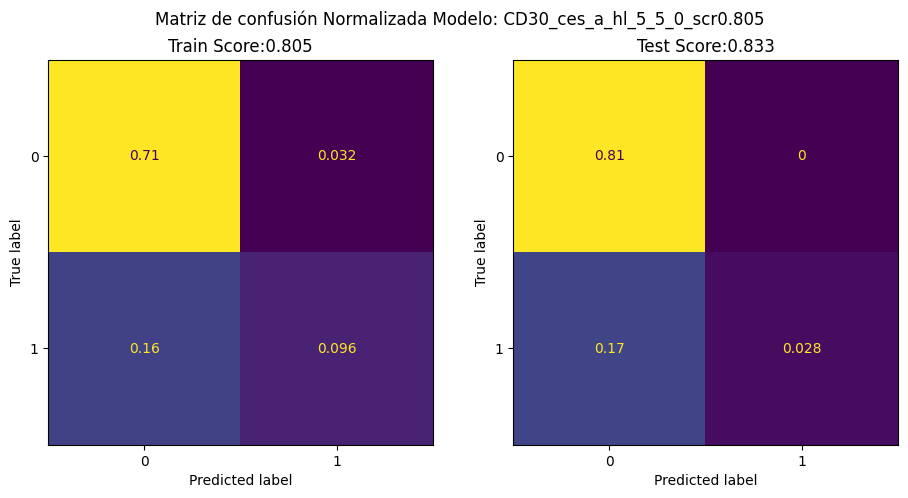

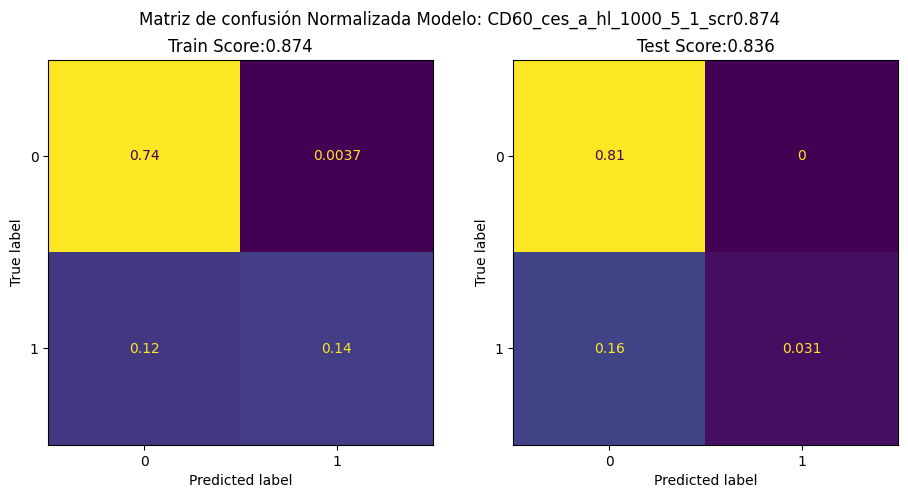

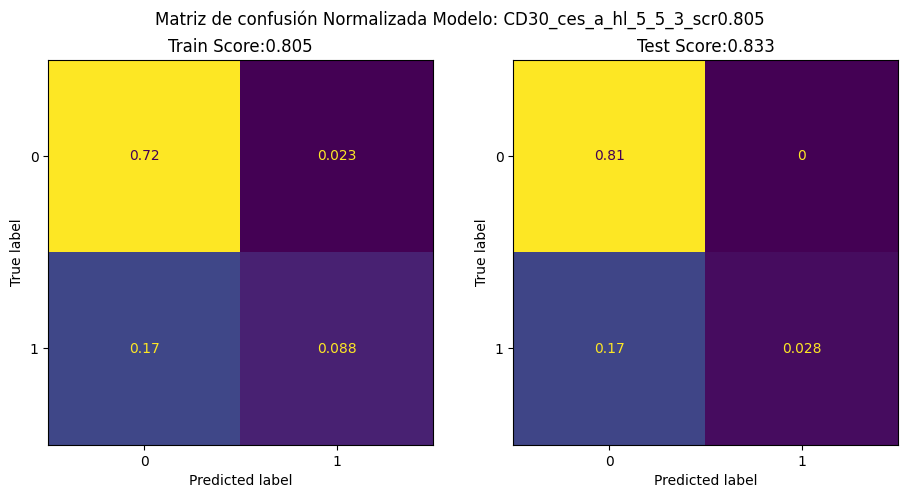

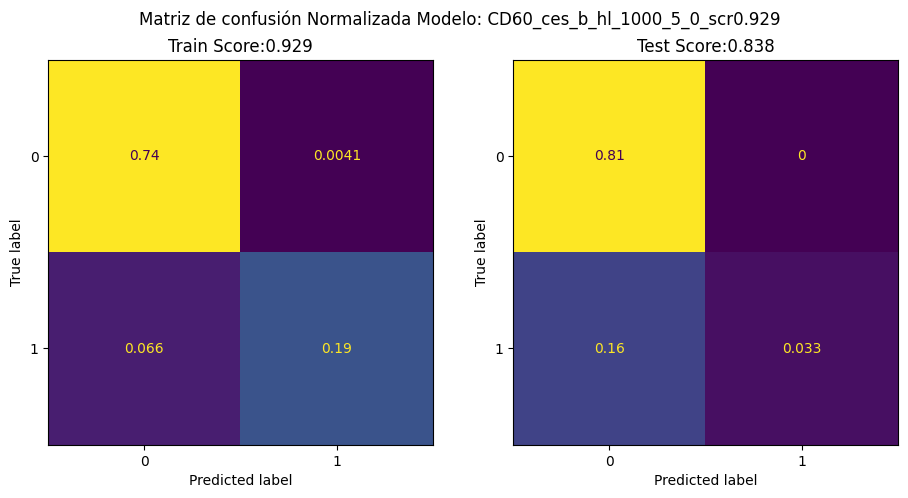

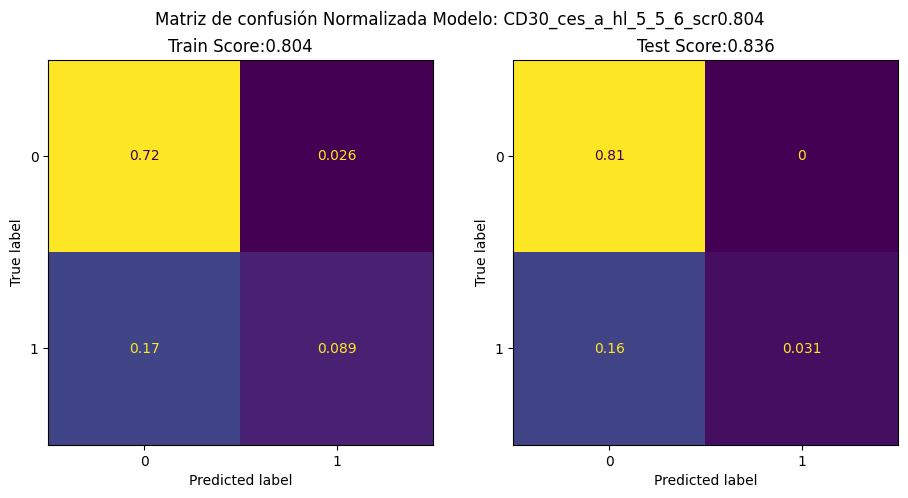

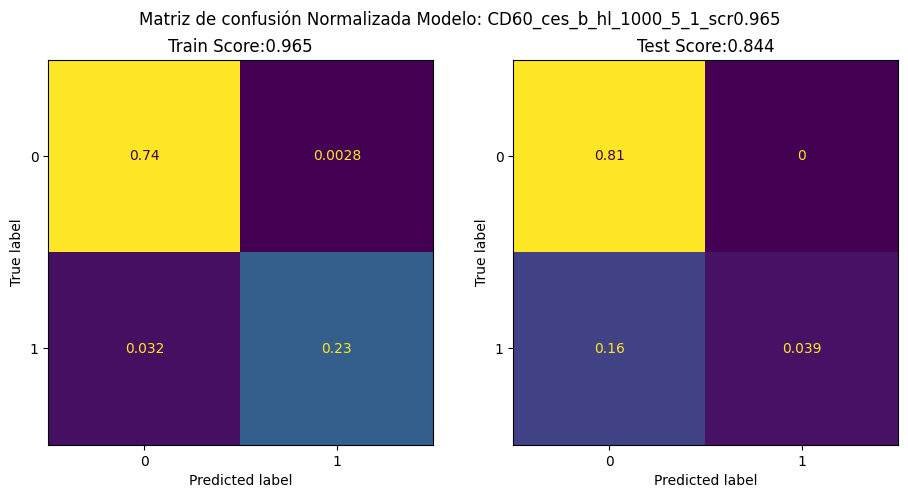

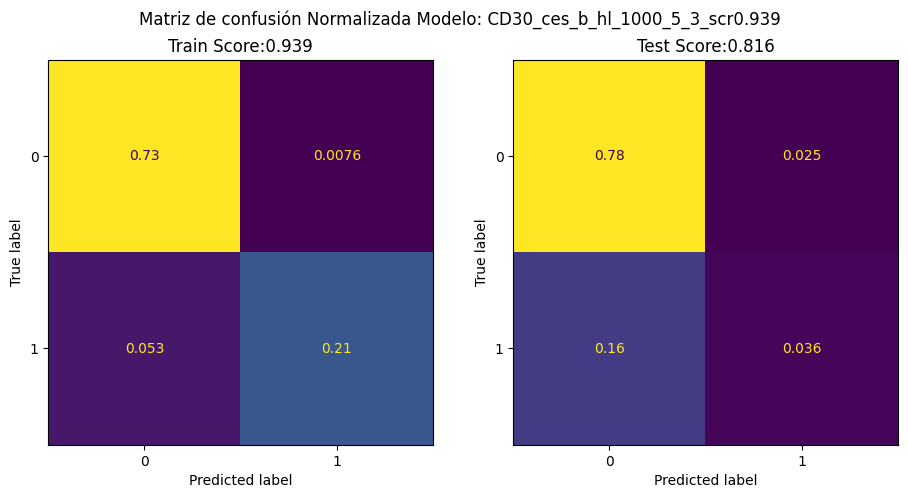

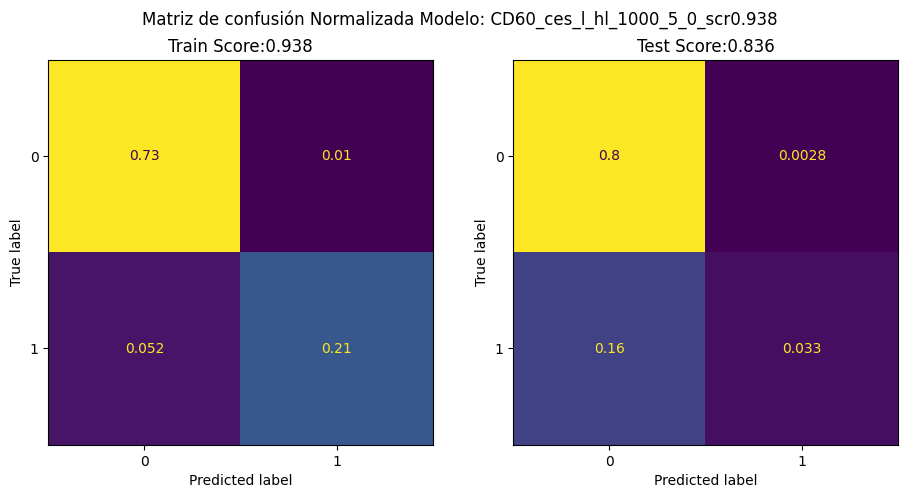

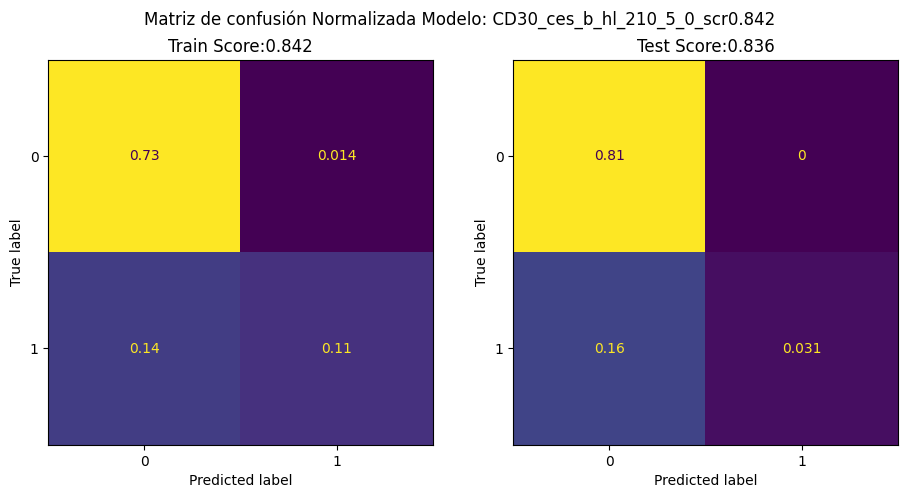

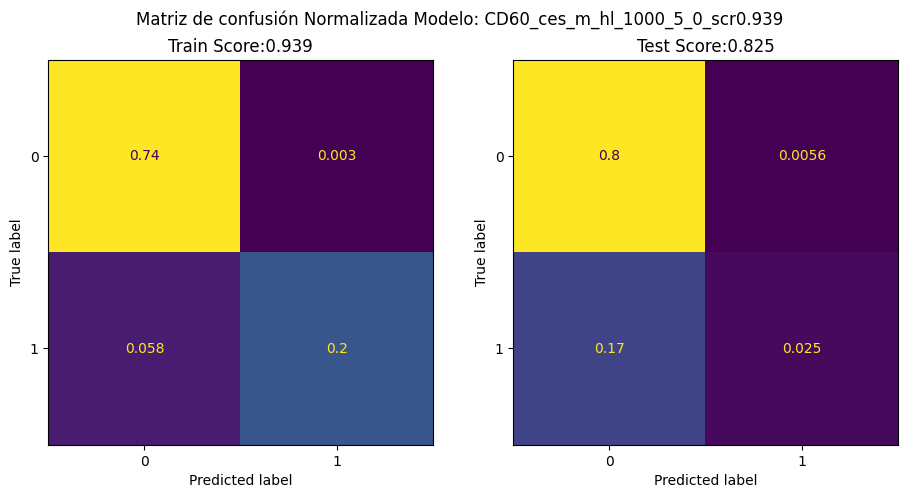

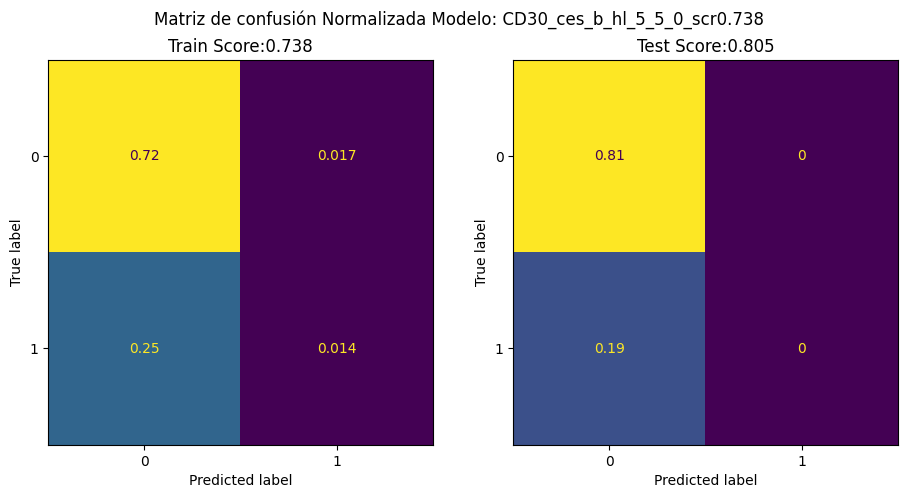

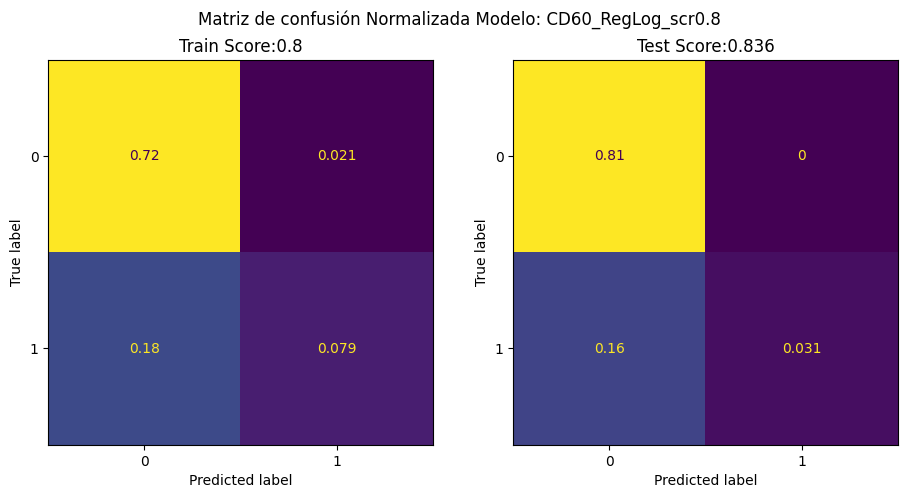

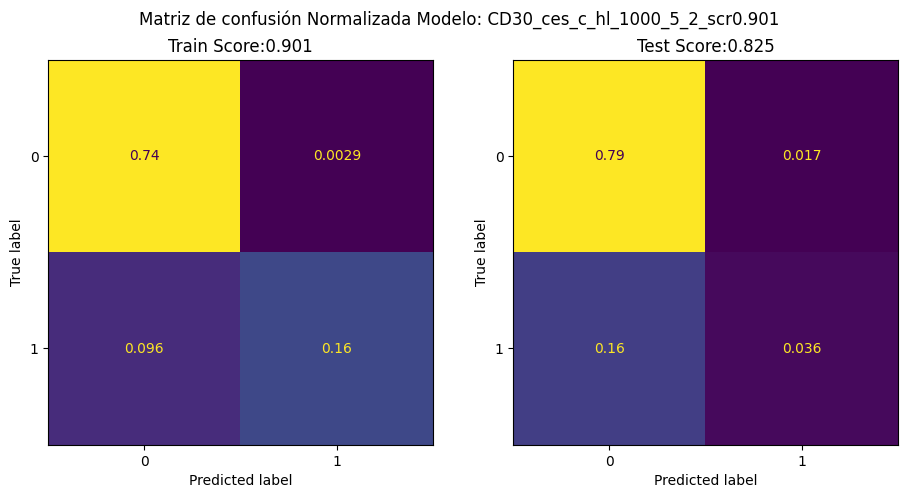

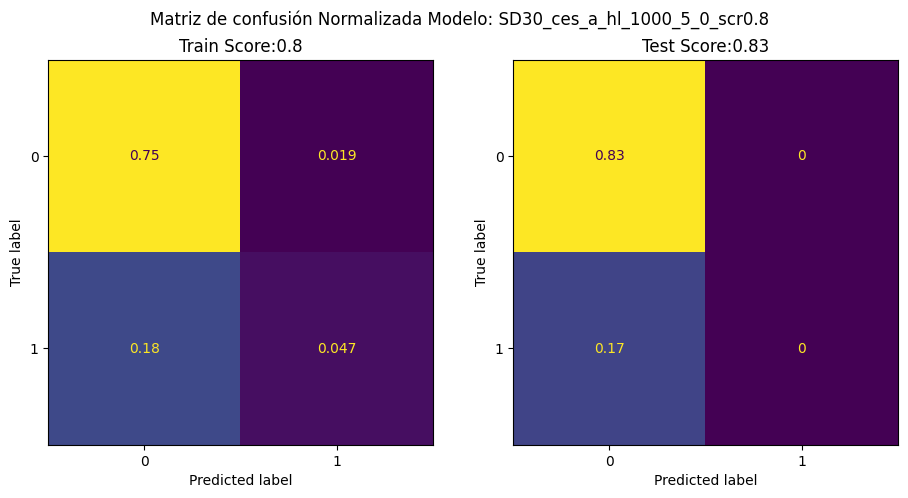

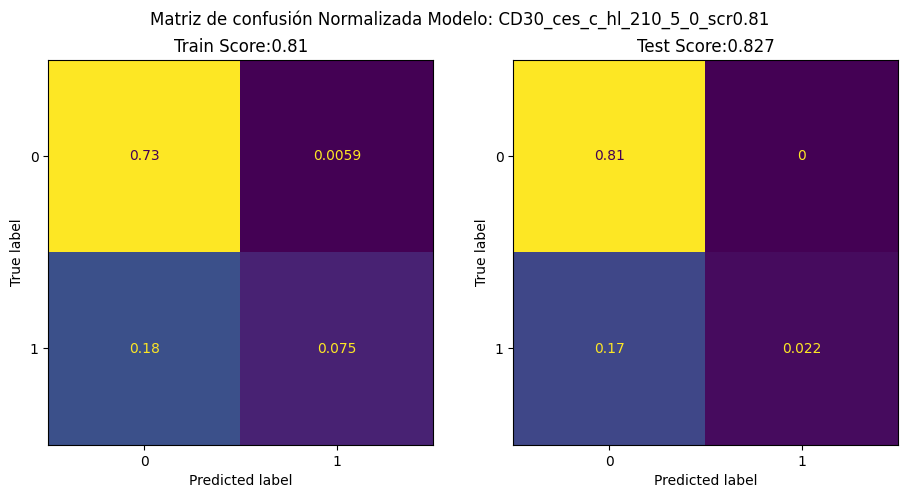

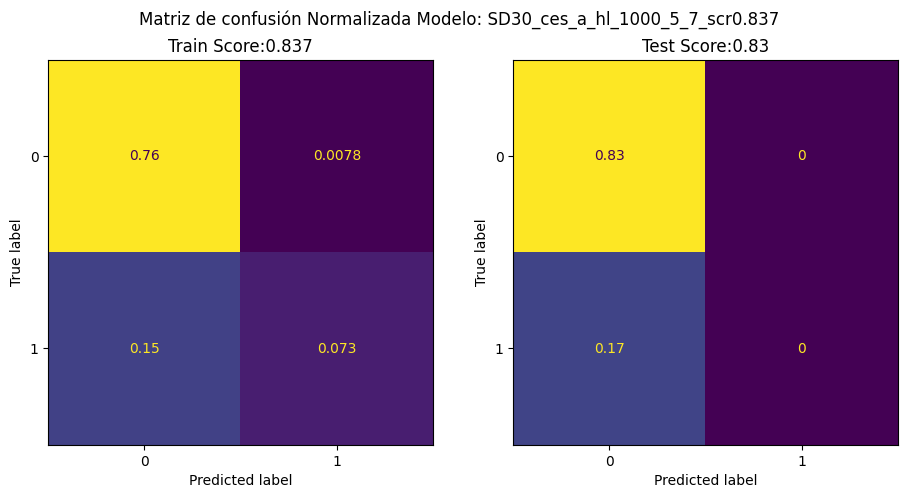

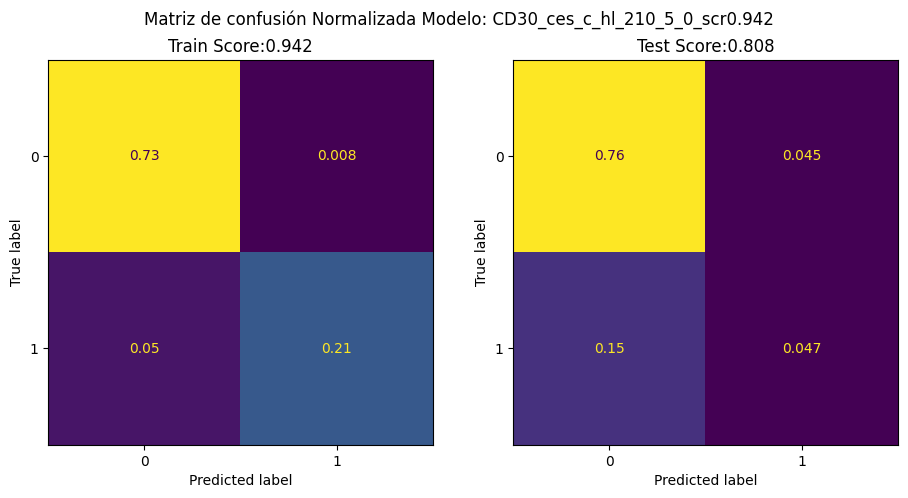

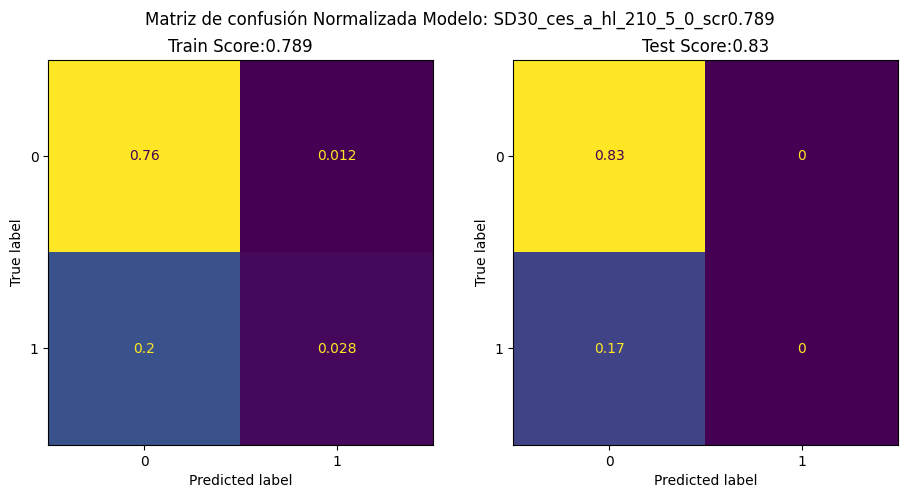

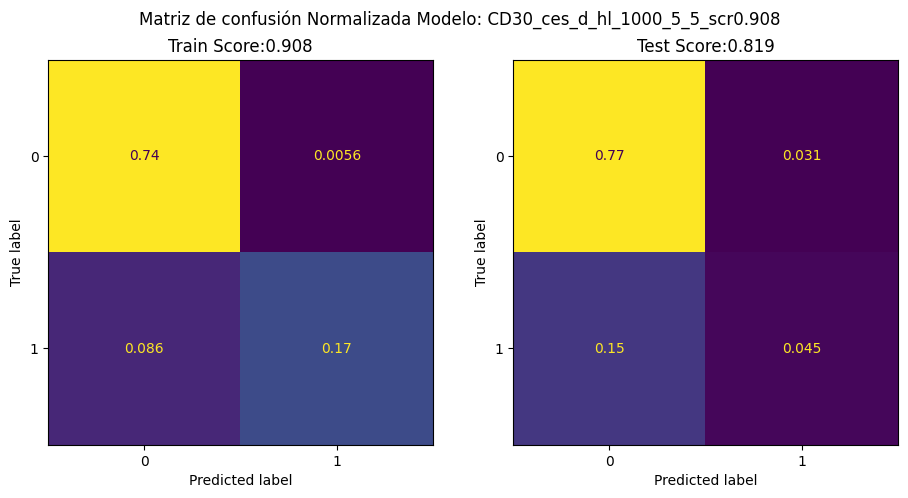

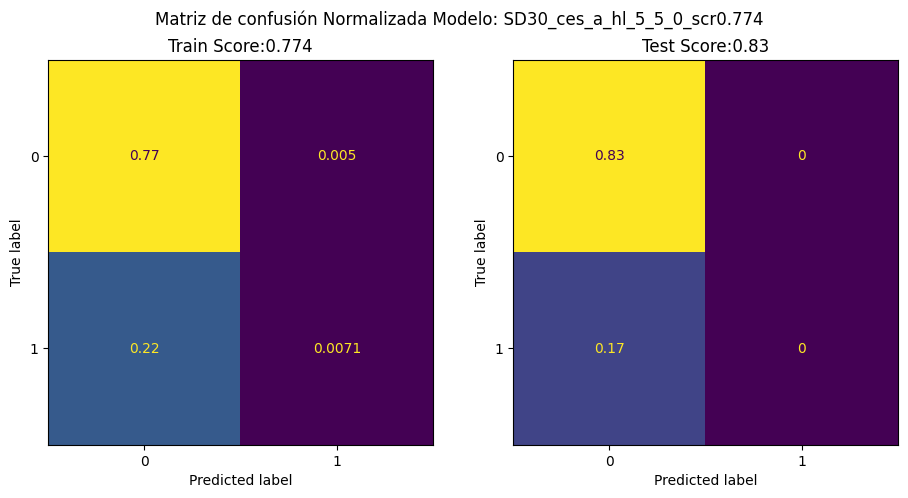

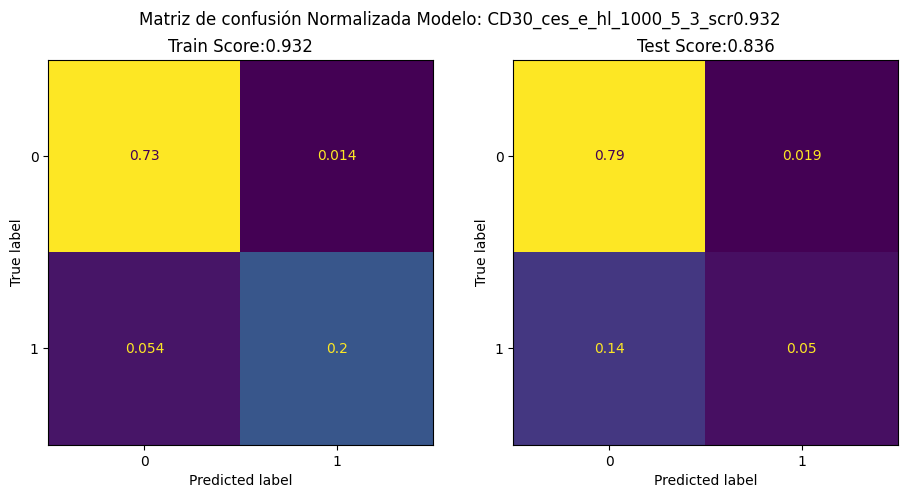

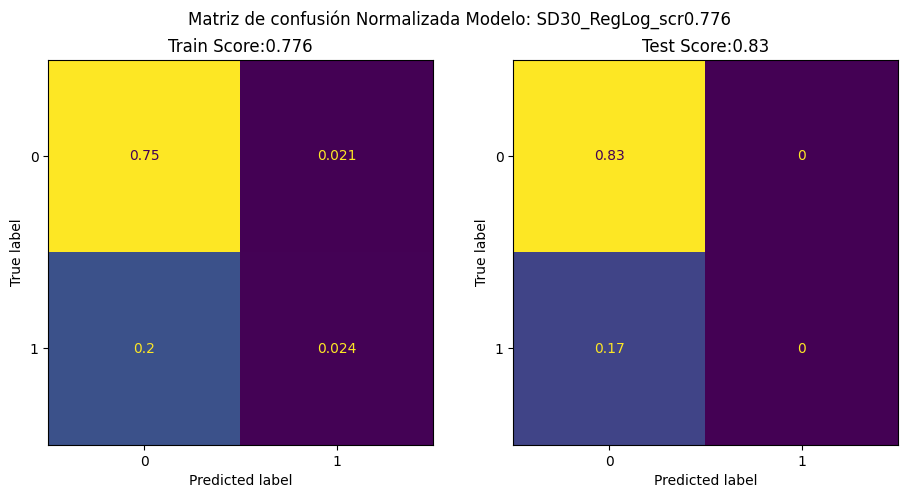

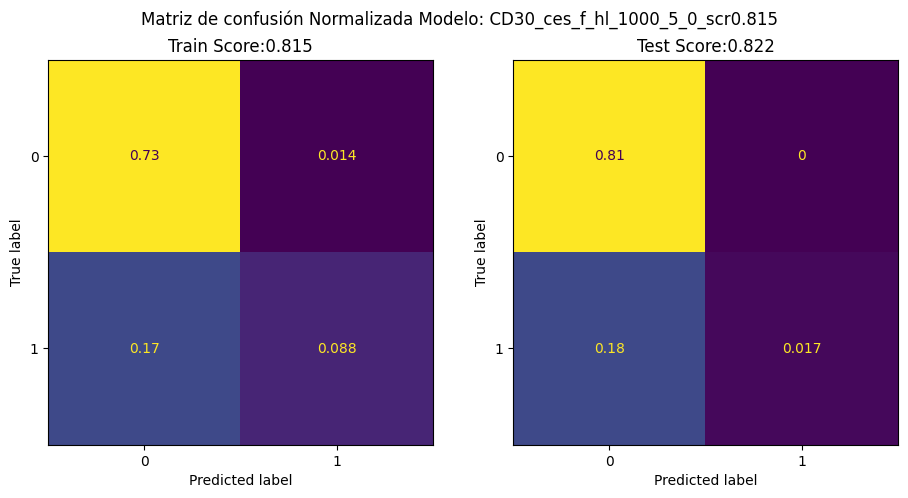

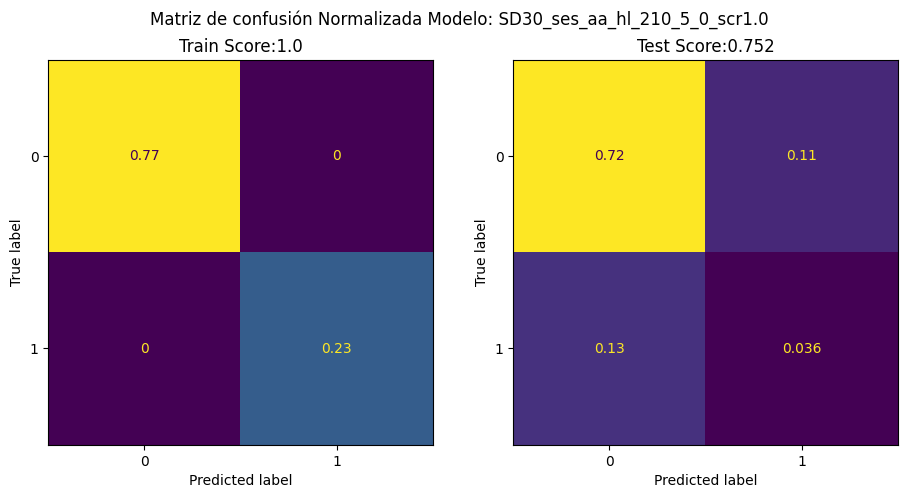

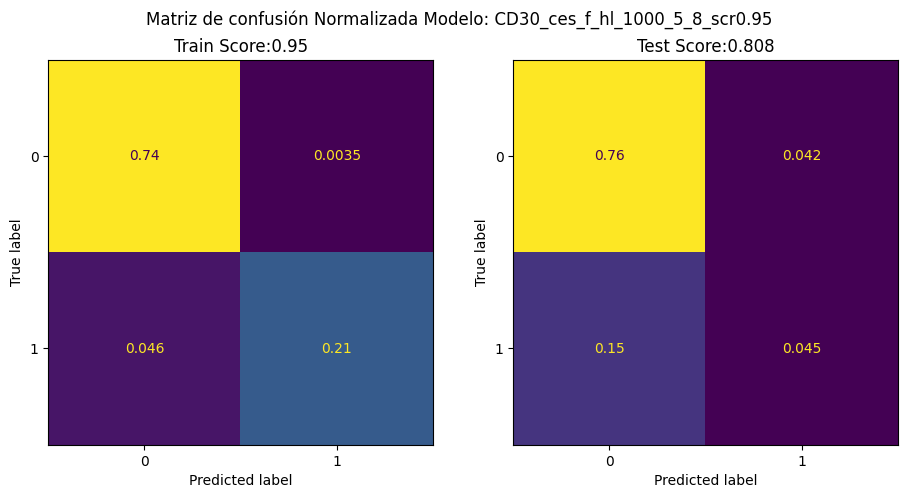

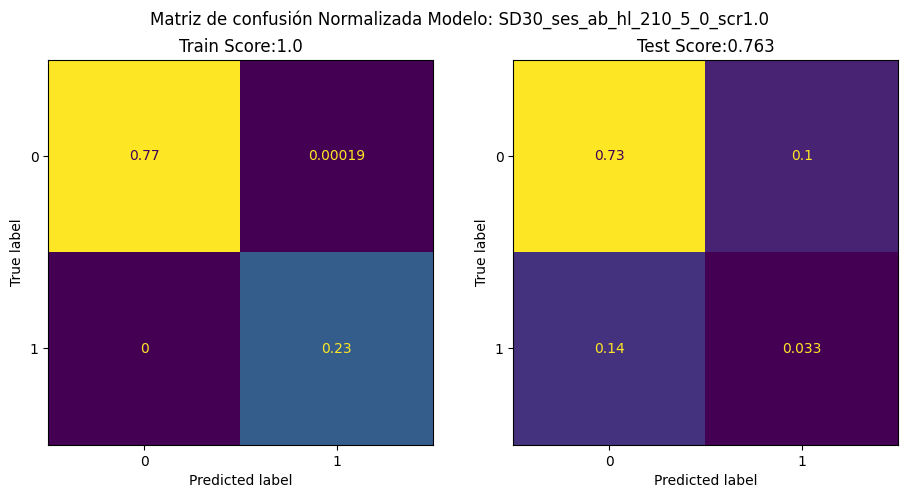

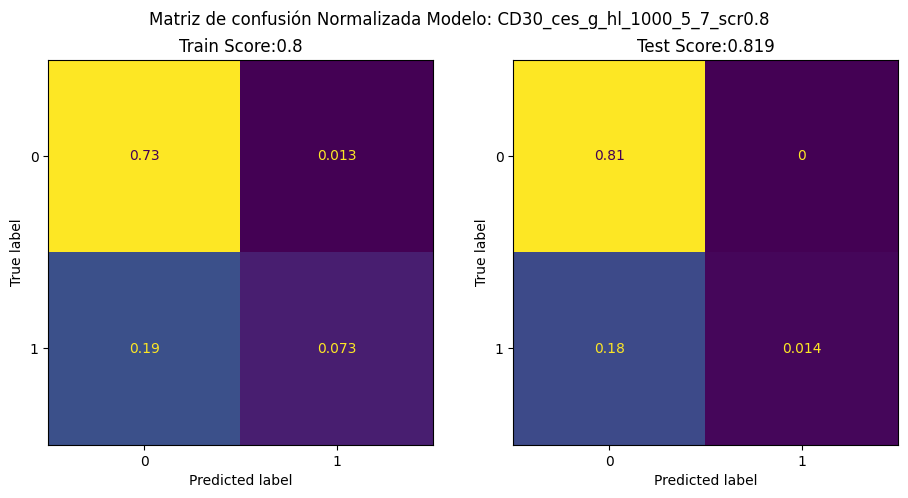

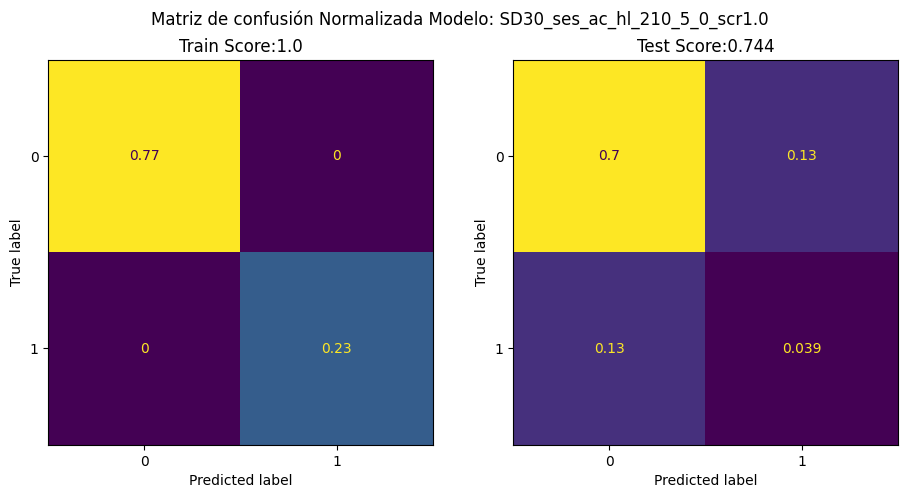

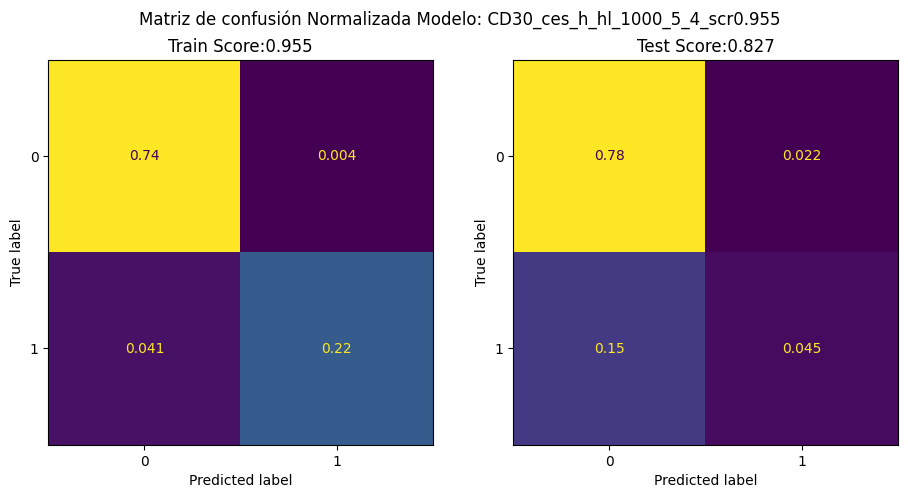

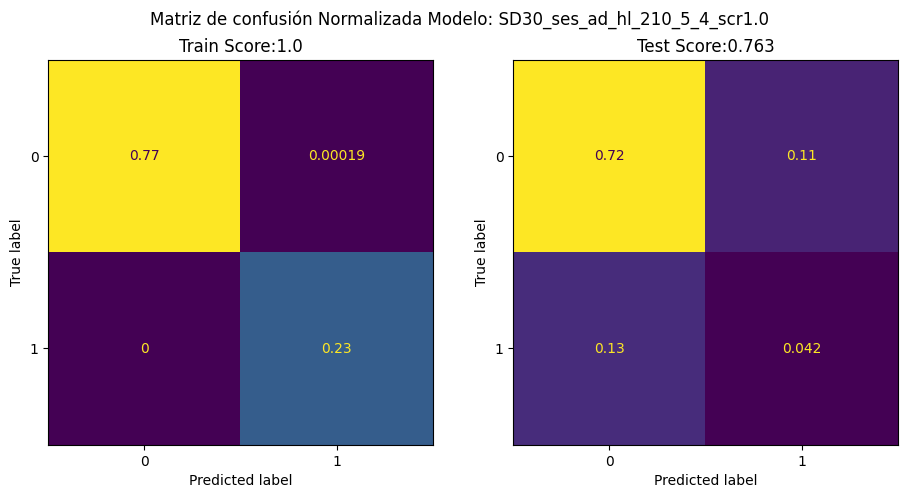

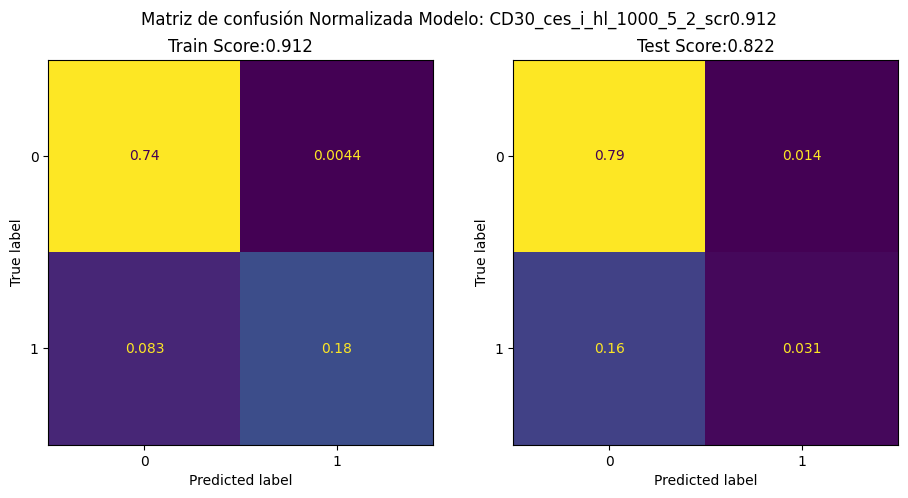

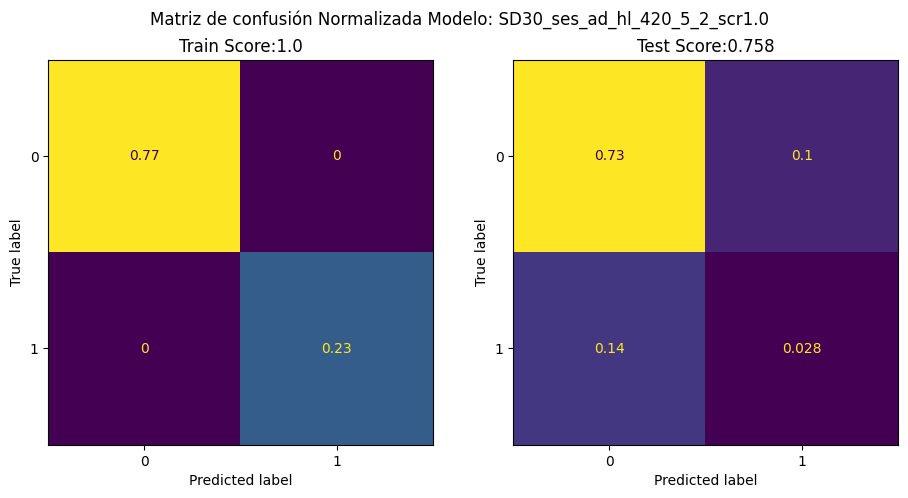

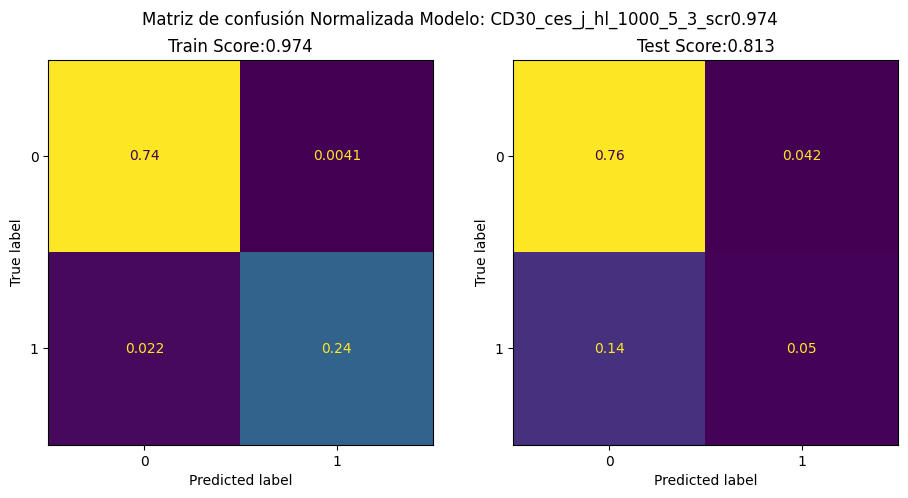

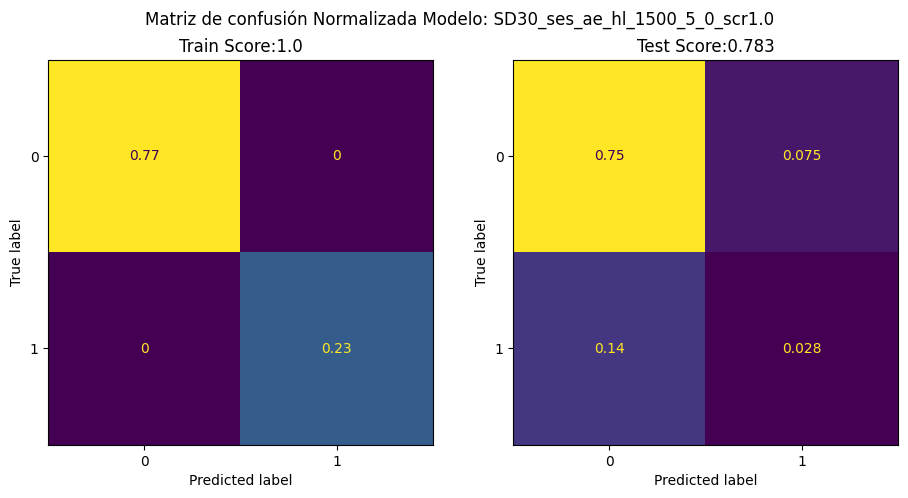

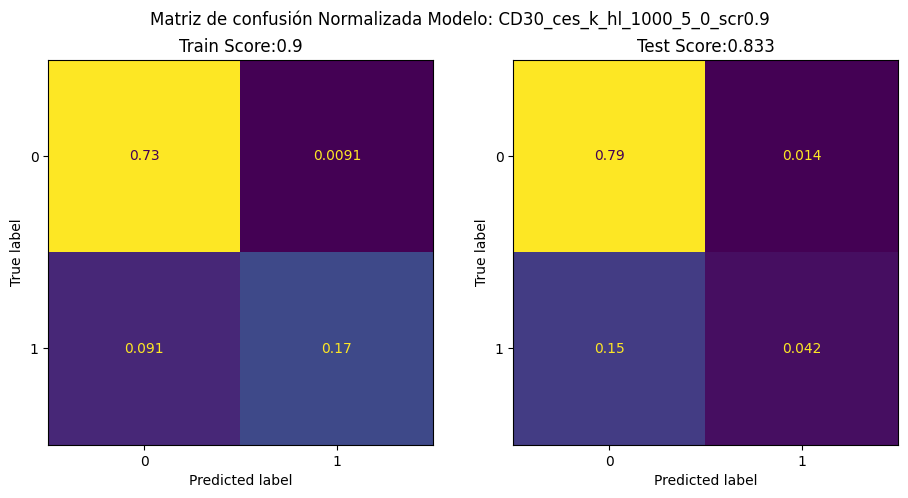

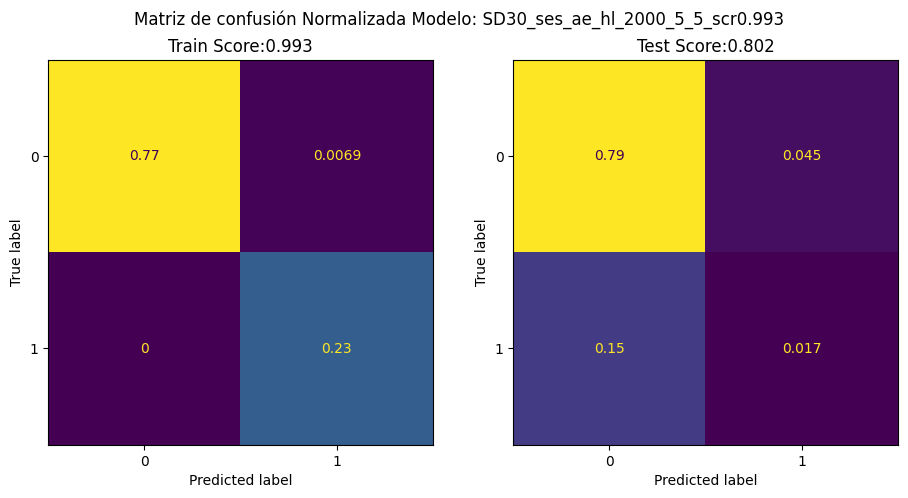

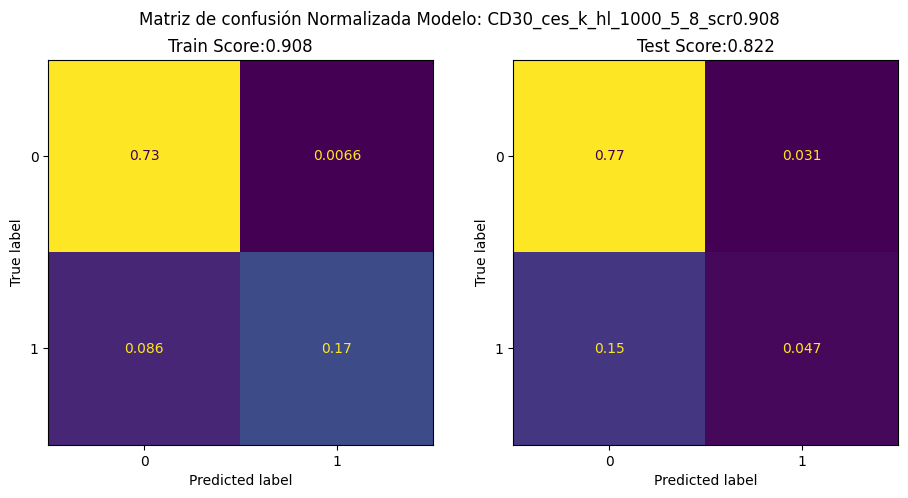

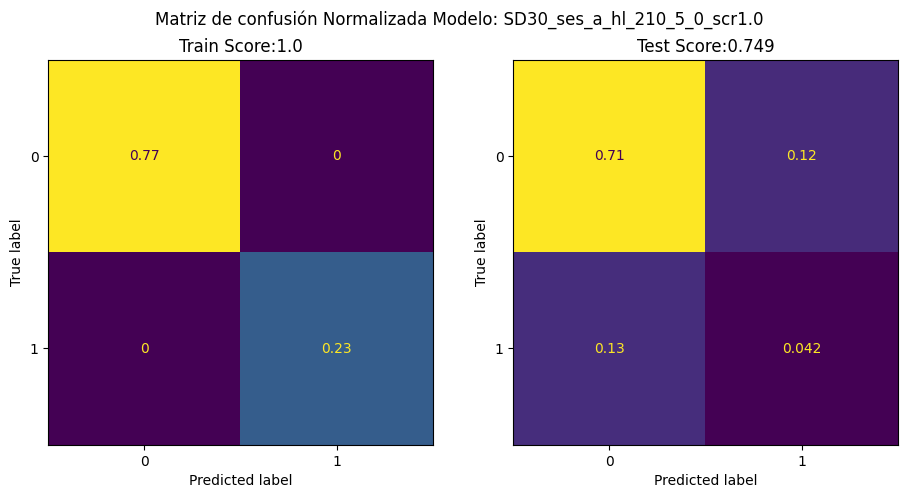

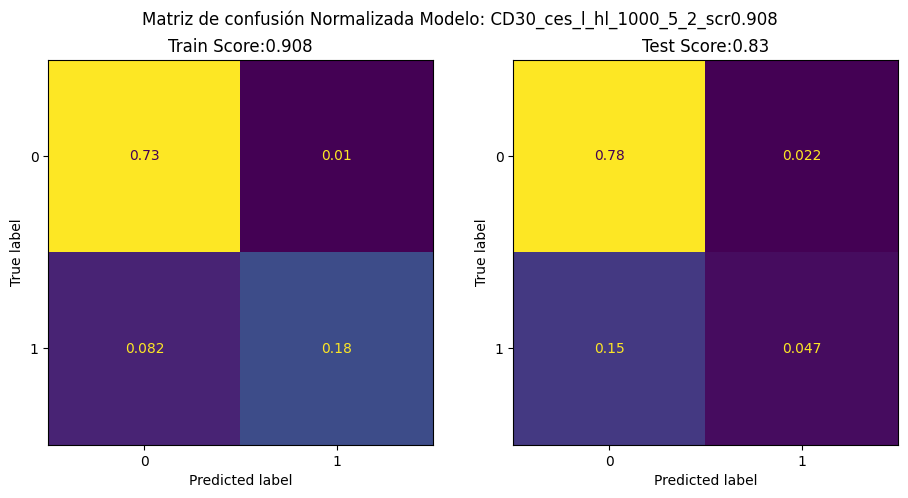

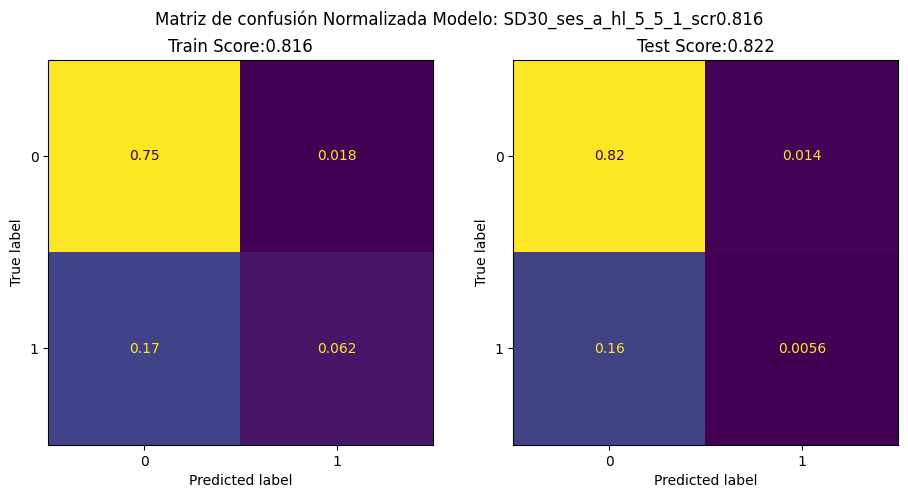

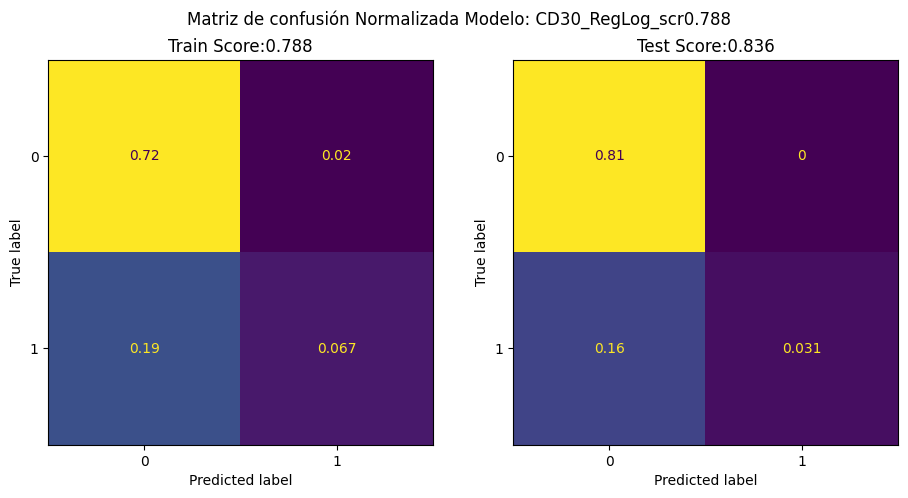

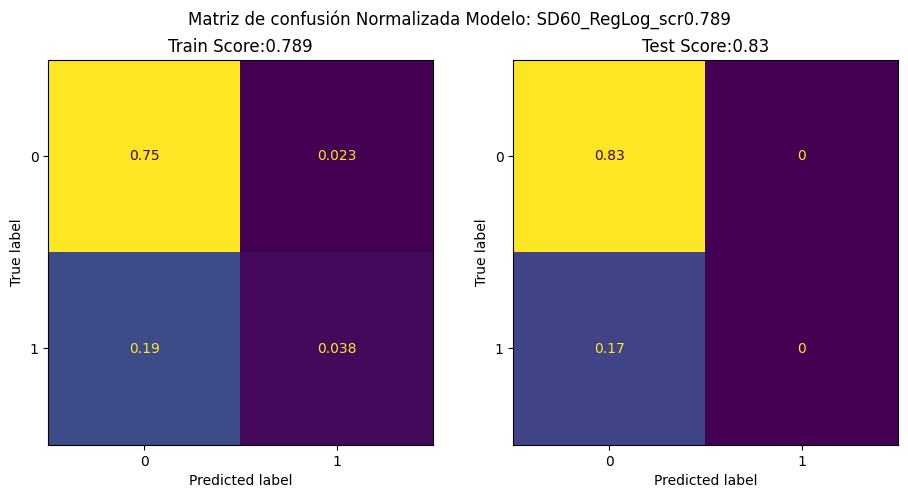

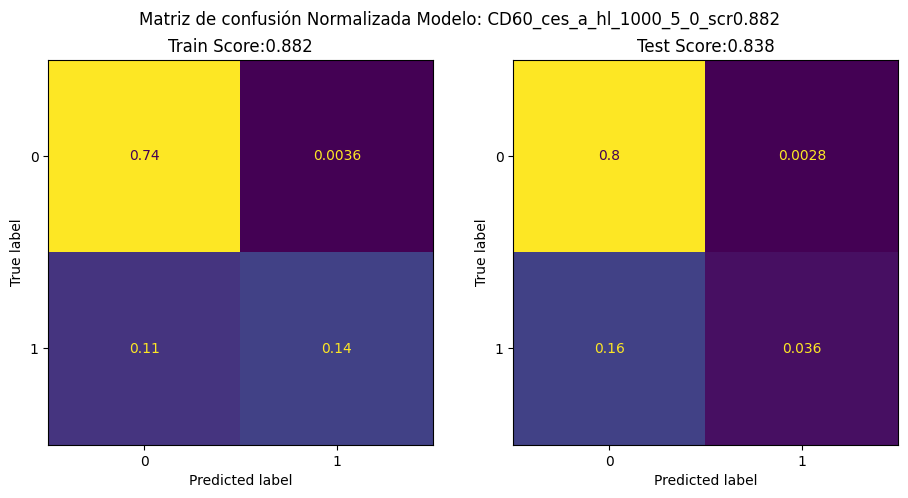

In [ ]:
dictPuntajes = {'Modelo':[],
                'V':[],
                'Train_Score':[],
                'Train_TN':[],
                'Train_FP':[],
                'Train_FN':[],
                'Train_TP':[],
                'Test_Score':[],
                'Test_TN':[],
                'Test_FP':[],
                'Test_FN':[],
                'Test_TP':[]}

for modelo in listaModelos:
  if 'joblib' in modelo:
    if 'D30' in modelo:
      dias_Considerar = 30
      if 'SD' in modelo:
        Xtest = np.loadtxt(pathDatos+'SD30_X2023.txt')
        ytest = np.loadtxt(pathDatos+'SD30_y2023.txt')
        Xtrain = np.loadtxt(pathDatos+'SD30_X2022.txt')
        ytrain= np.loadtxt(pathDatos+'SD30_y2022.txt')

      if 'CD' in modelo:
        Xtest = np.loadtxt(pathDatos+'CD30_X2023.txt')
        ytest = np.loadtxt(pathDatos+'CD30_y2023.txt')
        Xtrain = np.loadtxt(pathDatos+'CD30_X2022.txt')
        ytrain = np.loadtxt(pathDatos+'CD30_y2022.txt')

    if 'D60' in modelo:
      dias_Considerar = 60
      if 'SD' in modelo:
        Xtest = np.loadtxt(pathDatos+'SD60_X2023.txt')
        ytest = np.loadtxt(pathDatos+'SD60_y2023.txt')
        Xtrain = np.loadtxt(pathDatos+'SD60_X2022.txt')
        ytrain = np.loadtxt(pathDatos+'SD60_y2022.txt')
      if 'CD' in modelo:
        Xtest = np.loadtxt(pathDatos+'CD60_X2023.txt')
        ytest = np.loadtxt(pathDatos+'CD60_y2023.txt')
        Xtrain = np.loadtxt(pathDatos+'CD60_X2022.txt')
        ytrain = np.loadtxt(pathDatos+'CD60_y2022.txt')

    modelo_P = load(pathModelos+modelo)
    # Train
    predichosModelo_Train = modelo_P.predict(Xtrain)
    scoreTrain = np.round(modelo_P.score(Xtrain, ytrain), 3)
    tn_Train, fp_Train, fn_Train, tp_Train = confusion_matrix(ytrain, predichosModelo_Train, normalize='all').ravel()

    # Test
    predichosModelo_Test = modelo_P.predict(Xtest)
    accuracyScore_Test = np.round(accuracy_score(ytest, predichosModelo_Test),3)
    tn_Test, fp_Test, fn_Test, tp_Test = confusion_matrix(ytest, predichosModelo_Test, normalize='all').ravel()

    # Incluir en la lista
    dictPuntajes['Modelo'].append(modelo[:-7])
    dictPuntajes['V'].append('v1')
    dictPuntajes['Train_Score'].append(scoreTrain)
    dictPuntajes['Train_TN'].append(tn_Train)
    dictPuntajes['Train_FP'].append(fp_Train)
    dictPuntajes['Train_FN'].append(fn_Train)
    dictPuntajes['Train_TP'].append(tp_Train)
    dictPuntajes['Test_Score'].append(accuracyScore_Test)
    dictPuntajes['Test_TN'].append(tn_Test)
    dictPuntajes['Test_FP'].append(fp_Test)
    dictPuntajes['Test_FN'].append(fn_Test)
    dictPuntajes['Test_TP'].append(tp_Test)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
    #Train

    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytrain, predichosModelo_Train, normalize='all'),
                           display_labels=modelo_P.classes_,
                           ).plot(ax=axs[0], colorbar=False)
    axs[0].set_title(f'Train Score:{scoreTrain}')

    #Test
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytest, predichosModelo_Test, normalize='all'),
                        display_labels=modelo_P.classes_,
                        ).plot(ax=axs[1], colorbar=False)
    axs[1].set_title(f'Test Score:{accuracyScore_Test}')

    plt.suptitle(f'Matriz de confusión Normalizada Modelo: {modelo[:-7]}')

    plt.savefig((pathSaveFiguras + f'v1_{modelo[:-7]}.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

    plt.show()
    print('\n')


df_V1 = pd.DataFrame.from_dict(dictPuntajes)
#df

In [ ]:
df_V1.to_csv(pathDatos+'df_ConfMatrix_V1.csv', index=False)
df_V1 = pd.read_csv(pathDatos+'df_ConfMatrix_V1.csv')
df_V1

,Modelo,V,Train_Score,Train_TN,Train_FP,Train_FN,Train_TP,Test_Score,Test_TN,Test_FP,Test_FN,Test_TP
0,CD30_ces_a_hl_5_5_0_scr0.805,v1,0.805,0.708416,0.032377,0.163117,0.096090,0.833,0.805014,0.000000,0.167131,0.027855
1,CD60_ces_a_hl_1000_5_1_scr0.874,v1,0.874,0.737871,0.003703,0.121808,0.136618,0.836,0.805014,0.000000,0.164345,0.030641
2,CD30_ces_a_hl_5_5_3_scr0.805,v1,0.805,0.717504,0.023289,0.171637,0.087570,0.833,0.805014,0.000000,0.167131,0.027855
3,CD60_ces_b_hl_1000_5_0_scr0.929,v1,0.929,0.737492,0.004082,0.066458,0.191968,0.838,0.805014,0.000000,0.161560,0.033426
4,CD30_ces_a_hl_5_5_6_scr0.804,v1,0.804,0.715232,0.025561,0.170595,0.088611,0.836,0.805014,0.000000,0.164345,0.030641
5,CD60_ces_b_hl_1000_5_1_scr0.965,v1,0.965,0.738821,0.002753,0.032090,0.226336,0.844,0.805014,0.000000,0.155989,0.038997
6,CD30_ces_b_hl_1000_5_3_scr0.939,v1,0.939,0.733220,0.007574,0.053394,0.205813,0.816,0.779944,0.025070,0.158774,0.036212
7,CD60_ces_l_hl_1000_5_0_scr0.938,v1,0.938,0.731605,0.009969,0.051552,0.206874,0.836,0.802228,0.002786,0.161560,0.033426
8,CD30_ces_b_hl_210_5_0_scr0.842,v1,0.842,0.726877,0.013917,0.144372,0.114835,0.836,0.805014,0.000000,0.164345,0.030641
9,CD60_ces_m_hl_1000_5_0_scr0.939,v1,0.939,0.738536,0.003038,0.058388,0.200038,0.825,0.799443,0.005571,0.169916,0.025070


## V2

In [ ]:
pathModelos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v2/'
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Figuras_MatrizConfusion/'

listaModelos = ['12meses__hl_1500_5_int2_scr0.996.joblib',
                '6meses__hl_1500_5_int0_scr0.998.joblib',
                '12meses__hl_2000_5_int0_scr0.773.joblib',
                '6meses__hl_2000_5_int0_scr0.999.joblib',
                '12meses__hl_210_5_int0_scr0.999.joblib',
                '6meses__hl_210_5_int0_scr1.0.joblib',
                '12meses__hl_210_5_int1_scr0.996.joblib',
                '6meses__hl_210_5_int1_scr0.996.joblib',
                '12meses__hl_420_5_int2_scr0.957.joblib',
                '6meses__hl_420_5_int0_scr0.987.joblib']

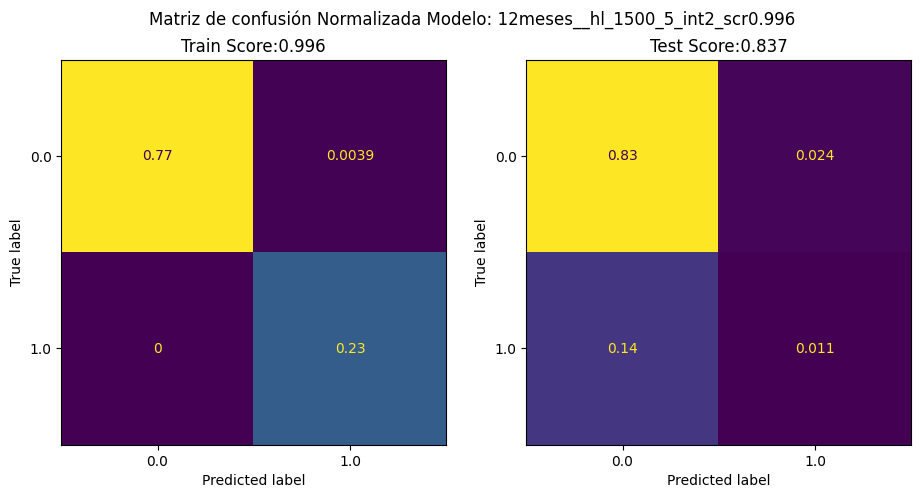

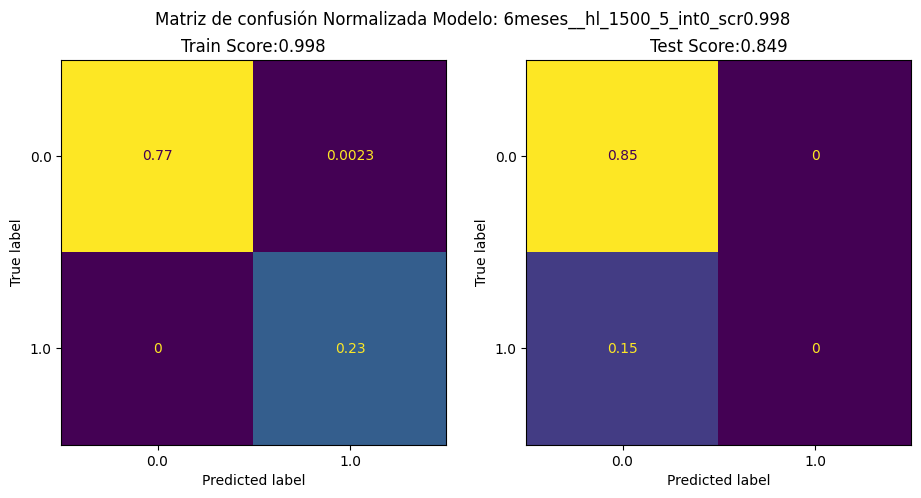

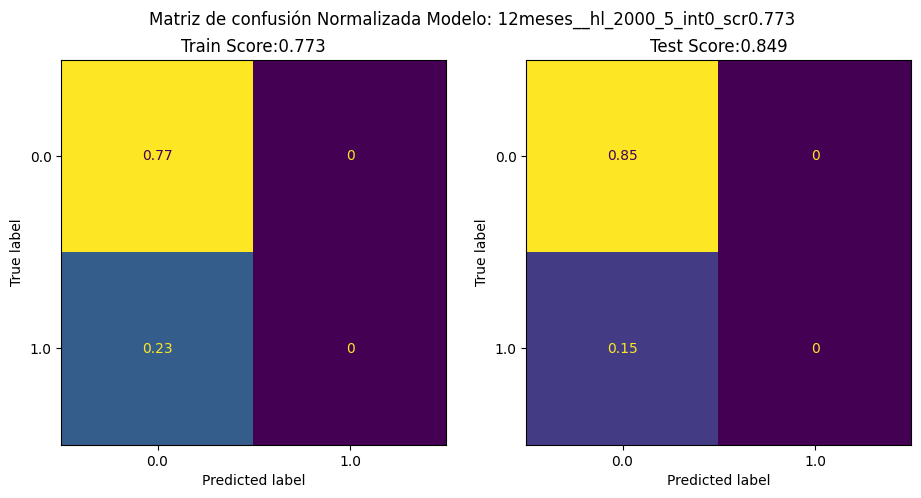

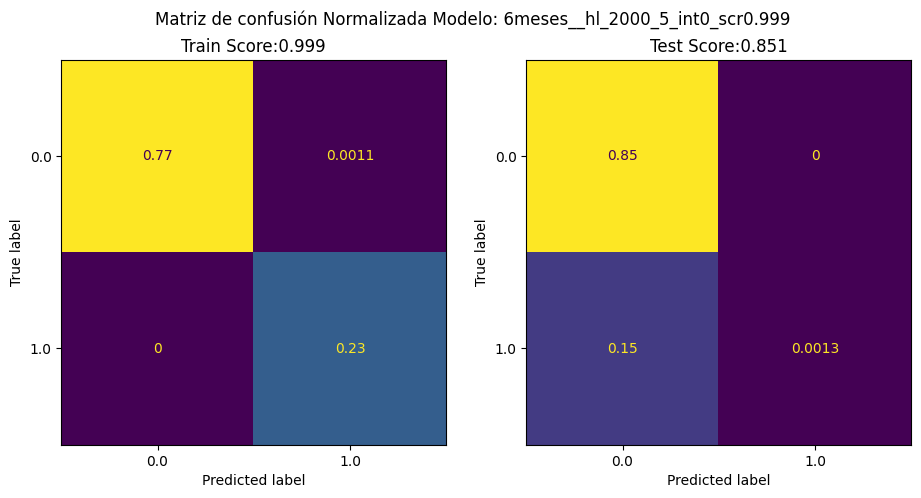

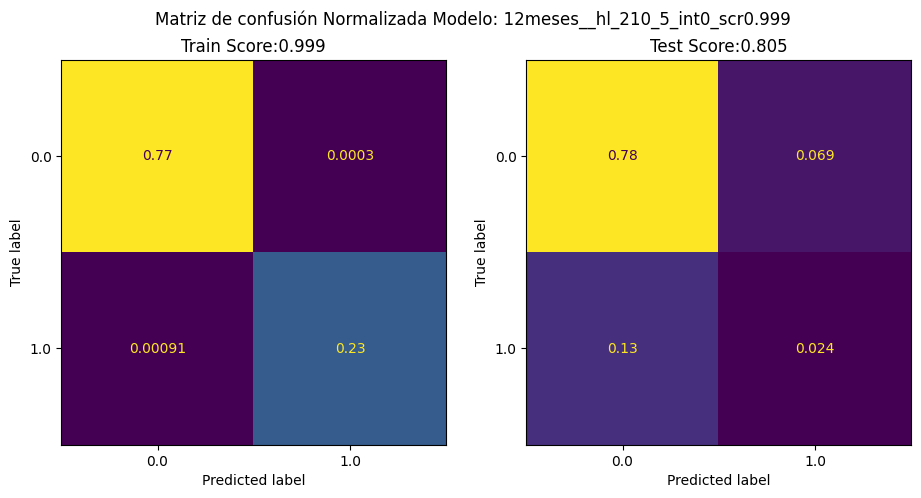

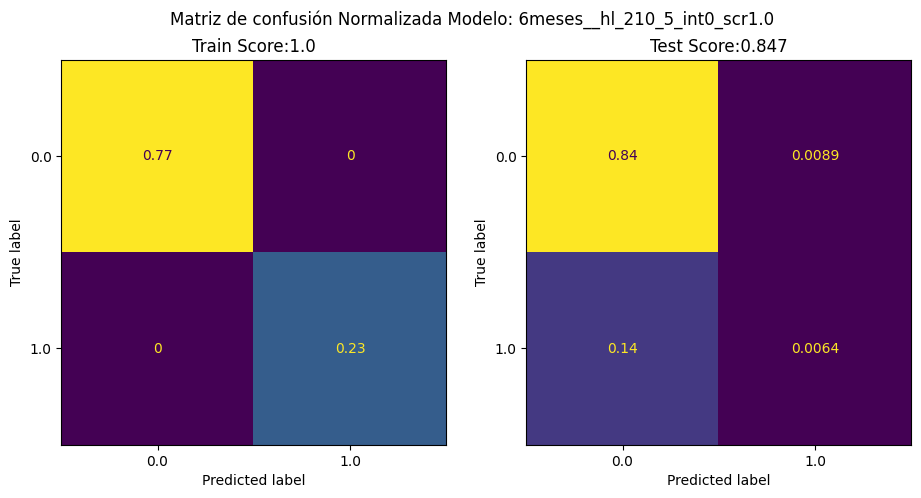

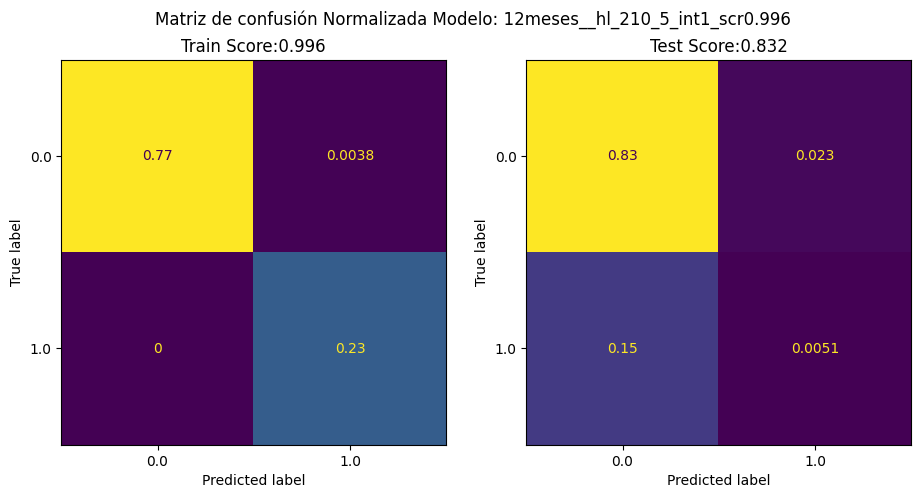

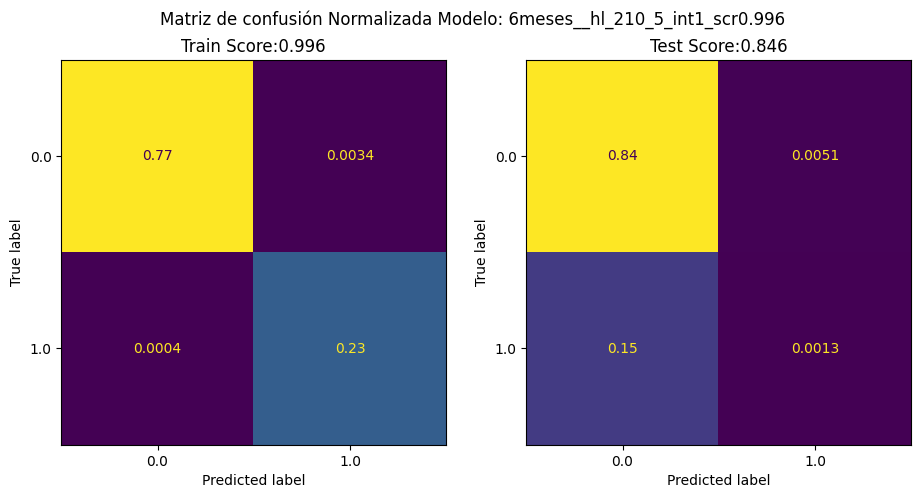

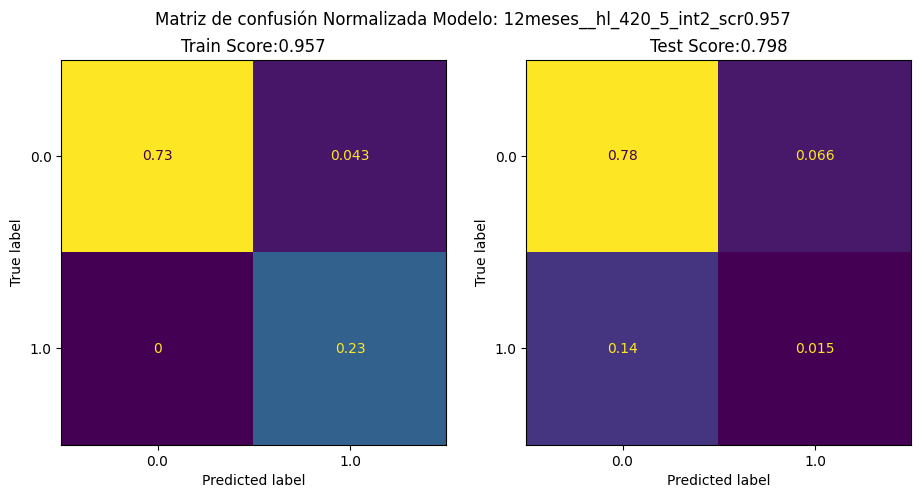

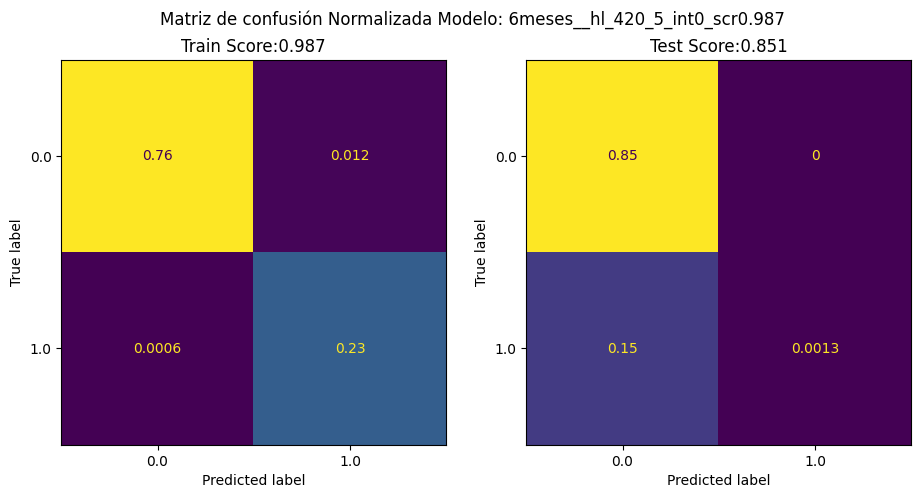

In [ ]:
dictPuntajes = {'Modelo':[],
                'V':[],
                'Train_Score':[],
                'Train_TN':[],
                'Train_FP':[],
                'Train_FN':[],
                'Train_TP':[],
                'Test_Score':[],
                'Test_TN':[],
                'Test_FP':[],
                'Test_FN':[],
                'Test_TP':[]}

for modelo in listaModelos:
  if 'joblib' in modelo:
    if '6meses' in modelo:
      dias_Considerar = 180
      Xtest = np.loadtxt(pathDatos+'6meses_X2022.txt')
      ytest = np.loadtxt(pathDatos+'6meses_y2022.txt')
      Xtrain = np.loadtxt(pathDatos+'6meses_X2021.txt')
      ytrain= np.loadtxt(pathDatos+'6meses_y2021.txt')

    if '12meses' in modelo:
      dias_Considerar = 180
      Xtest = np.loadtxt(pathDatos+'12meses_X2022.txt')
      ytest = np.loadtxt(pathDatos+'12meses_y2022.txt')
      Xtrain = np.loadtxt(pathDatos+'12meses_X2021.txt')
      ytrain= np.loadtxt(pathDatos+'12meses_y2021.txt')

    modelo_P = load(pathModelos+modelo)
    # Train
    predichosModelo_Train = modelo_P.predict(Xtrain)
    scoreTrain = np.round(modelo_P.score(Xtrain, ytrain), 3)
    tn_Train, fp_Train, fn_Train, tp_Train = confusion_matrix(ytrain, predichosModelo_Train, normalize='all').ravel()

    # Test
    predichosModelo_Test = modelo_P.predict(Xtest)
    accuracyScore_Test = np.round(accuracy_score(ytest, predichosModelo_Test),3)
    tn_Test, fp_Test, fn_Test, tp_Test = confusion_matrix(ytest, predichosModelo_Test, normalize='all').ravel()

    # Incluir en la lista
    dictPuntajes['Modelo'].append(modelo[:-7])
    dictPuntajes['V'].append('v2')
    dictPuntajes['Train_Score'].append(scoreTrain)
    dictPuntajes['Train_TN'].append(tn_Train)
    dictPuntajes['Train_FP'].append(fp_Train)
    dictPuntajes['Train_FN'].append(fn_Train)
    dictPuntajes['Train_TP'].append(tp_Train)
    dictPuntajes['Test_Score'].append(accuracyScore_Test)
    dictPuntajes['Test_TN'].append(tn_Test)
    dictPuntajes['Test_FP'].append(fp_Test)
    dictPuntajes['Test_FN'].append(fn_Test)
    dictPuntajes['Test_TP'].append(tp_Test)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
    #Train

    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytrain, predichosModelo_Train, normalize='all'),
                           display_labels=modelo_P.classes_,
                           ).plot(ax=axs[0], colorbar=False)
    axs[0].set_title(f'Train Score:{scoreTrain}')

    #Test
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytest, predichosModelo_Test, normalize='all'),
                        display_labels=modelo_P.classes_,
                        ).plot(ax=axs[1], colorbar=False)
    axs[1].set_title(f'Test Score:{accuracyScore_Test}')

    plt.suptitle(f'Matriz de confusión Normalizada Modelo: {modelo[:-7]}')

    plt.savefig((pathSaveFiguras + f'v2_{modelo[:-7]}.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

    plt.show()
    print('\n')


df_V2 = pd.DataFrame.from_dict(dictPuntajes)
#df

In [ ]:
df_V2.to_csv(pathDatos+'df_ConfMatrix_V2.csv', index=False)
df_V2 = pd.read_csv(pathDatos+'df_ConfMatrix_V2.csv')
df_V2

,Modelo,V,Train_Score,Train_TN,Train_FP,Train_FN,Train_TP,Test_Score,Test_TN,Test_FP,Test_FN,Test_TP
0,12meses__hl_1500_5_int2_scr0.996,v2,0.996,0.769340,0.003853,0.000000,0.226807,0.837,0.825255,0.024235,0.139031,0.011480
1,6meses__hl_1500_5_int0_scr0.998,v2,0.998,0.769009,0.002289,0.000000,0.228702,0.849,0.849490,0.000000,0.150510,0.000000
2,12meses__hl_2000_5_int0_scr0.773,v2,0.773,0.773193,0.000000,0.226807,0.000000,0.849,0.849490,0.000000,0.150510,0.000000
3,6meses__hl_2000_5_int0_scr0.999,v2,0.999,0.770203,0.001095,0.000000,0.228702,0.851,0.849490,0.000000,0.149235,0.001276
4,12meses__hl_210_5_int0_scr0.999,v2,0.999,0.772889,0.000304,0.000913,0.225895,0.805,0.780612,0.068878,0.126276,0.024235
5,6meses__hl_210_5_int0_scr1.0,v2,1.000,0.771298,0.000000,0.000000,0.228702,0.847,0.840561,0.008929,0.144133,0.006378
6,12meses__hl_210_5_int1_scr0.996,v2,0.996,0.769441,0.003751,0.000000,0.226807,0.832,0.826531,0.022959,0.145408,0.005102
7,6meses__hl_210_5_int1_scr0.996,v2,0.996,0.767914,0.003384,0.000398,0.228304,0.846,0.844388,0.005102,0.149235,0.001276
8,12meses__hl_420_5_int2_scr0.957,v2,0.957,0.729798,0.043395,0.000000,0.226807,0.798,0.783163,0.066327,0.135204,0.015306
9,6meses__hl_420_5_int0_scr0.987,v2,0.987,0.759256,0.012042,0.000597,0.228105,0.851,0.849490,0.000000,0.149235,0.001276


## V3

In [ ]:
pathModelos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v3/'
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Figuras_MatrizConfusion/'

listaModelos = ['LGR2_hl_1_1_int0_scr0.736.joblib',
                'LGR_hl_1_1_int0_scr0.736.joblib',
                'LGR2_hl_1500_5_int0_scr0.736.joblib',
                'LGR_hl_1500_5_int0_scr0.736.joblib',
                'LGR2_hl_2000_5_int0_scr0.736.joblib',
                'LGR_hl_2000_5_int0_scr0.736.joblib',
                'LGR2_hl_210_5_int0_scr0.736.joblib',
                'LGR_hl_210_5_int0_scr0.736.joblib',
                'LGR2_hl_420_5_int0_scr0.733.joblib',
                'LGR_hl_420_5_int0_scr0.736.joblib',
                'LGR2_hl_5_5_int0_scr0.736.joblib',
                'LGR_hl_5_5_int0_scr0.736.joblib',
                'LGR2_hl_8_8_int0_scr0.736.joblib',
                'LGR_hl_8_8_int0_scr0.736.joblib']

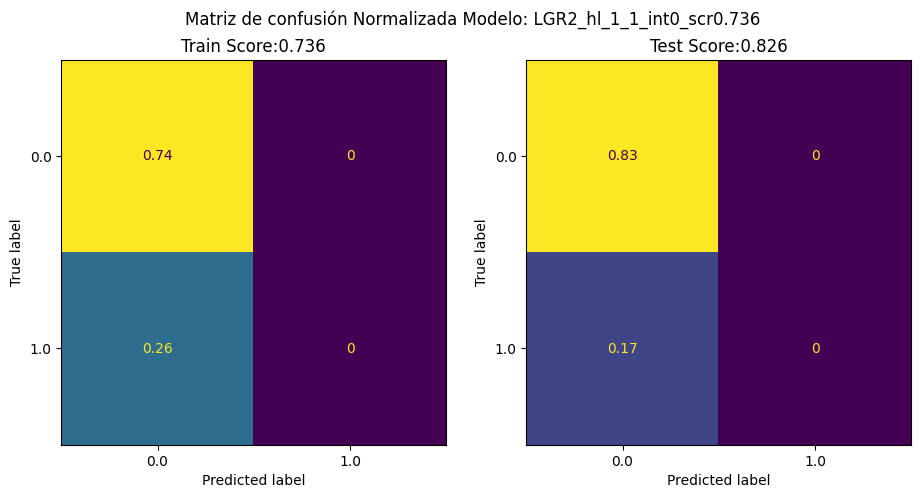

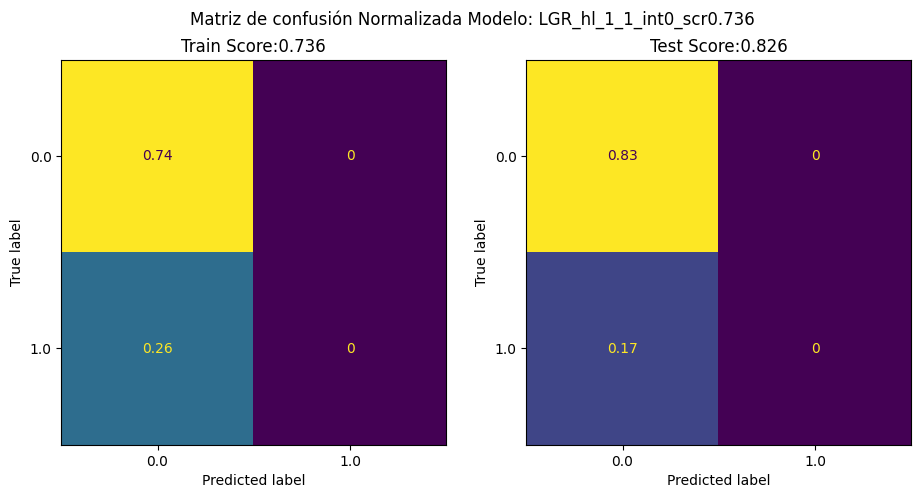

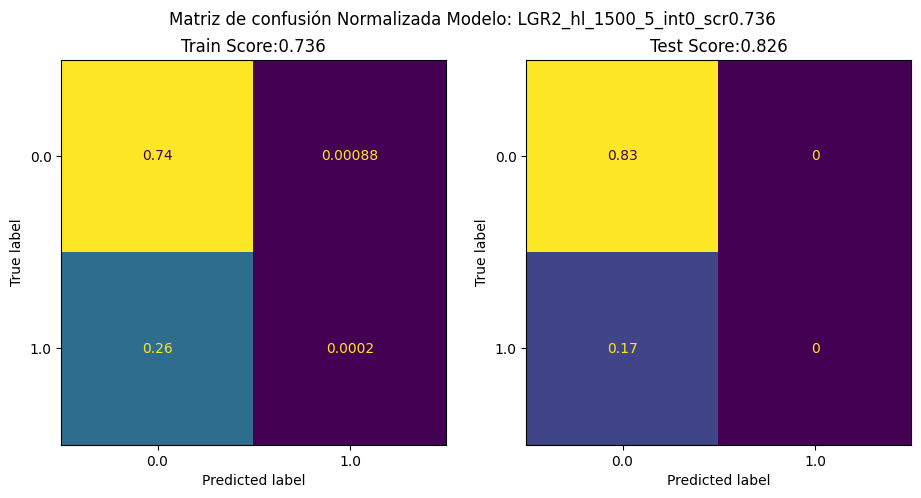

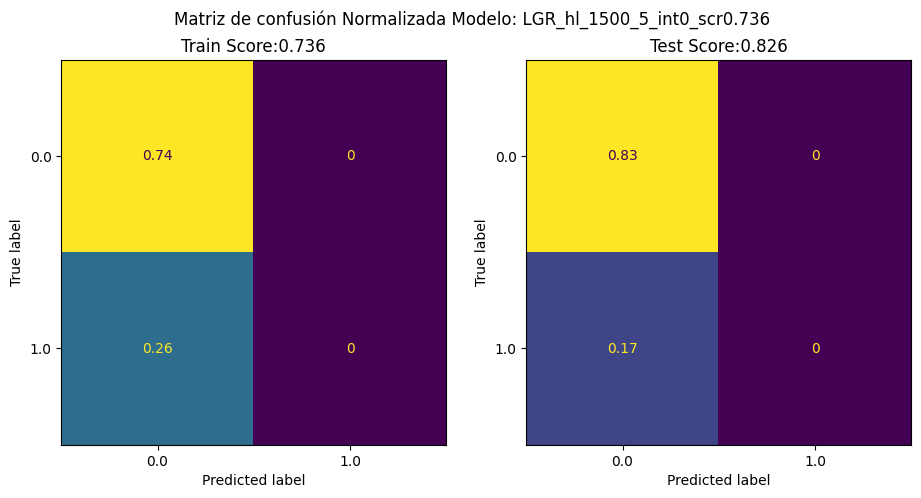

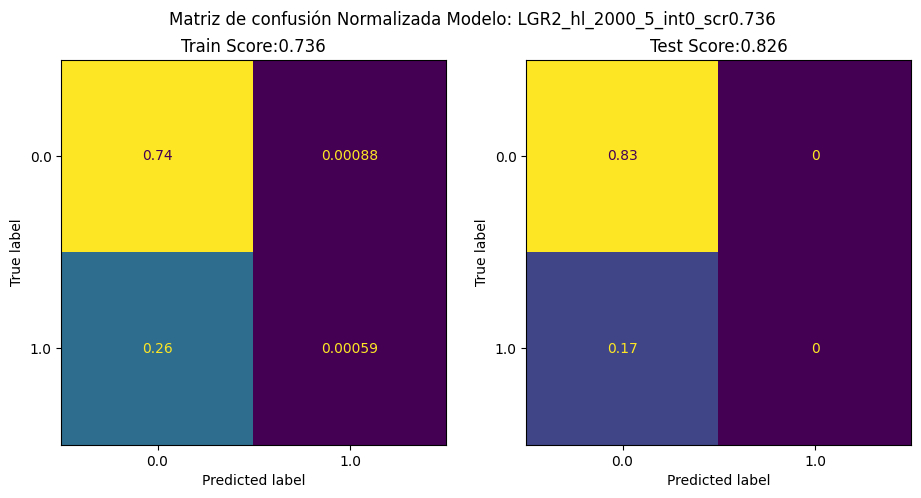

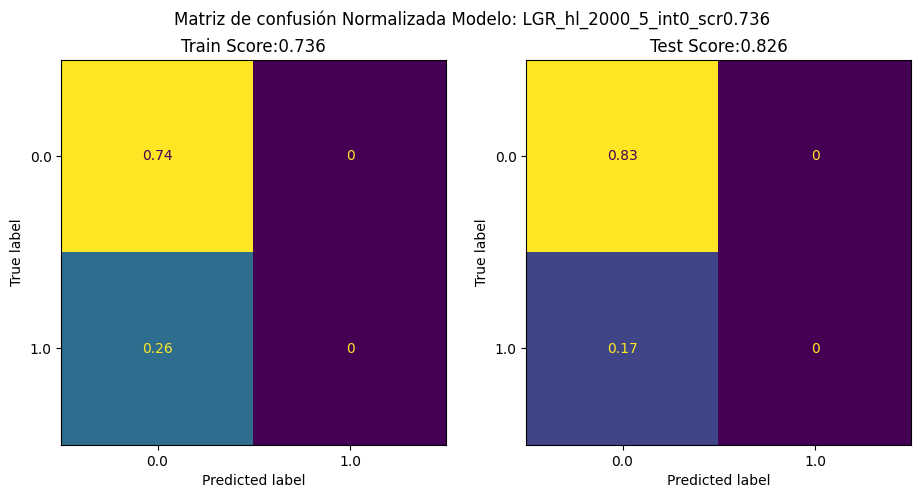

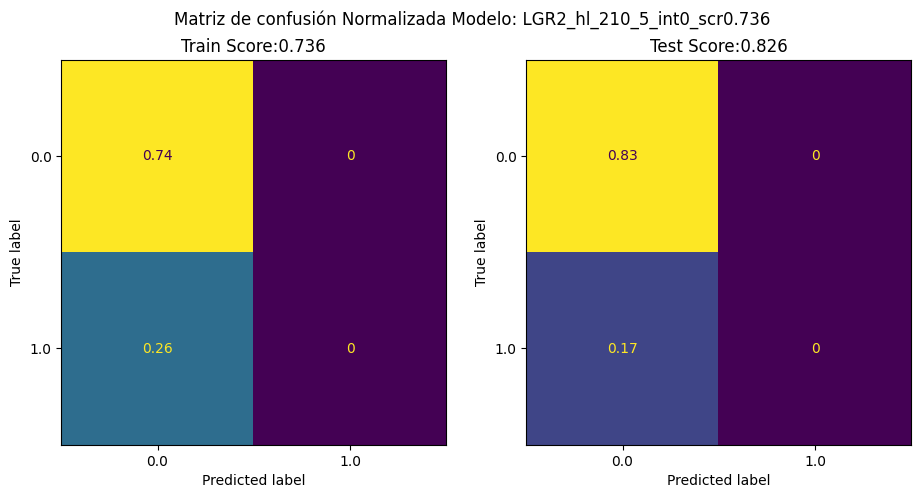

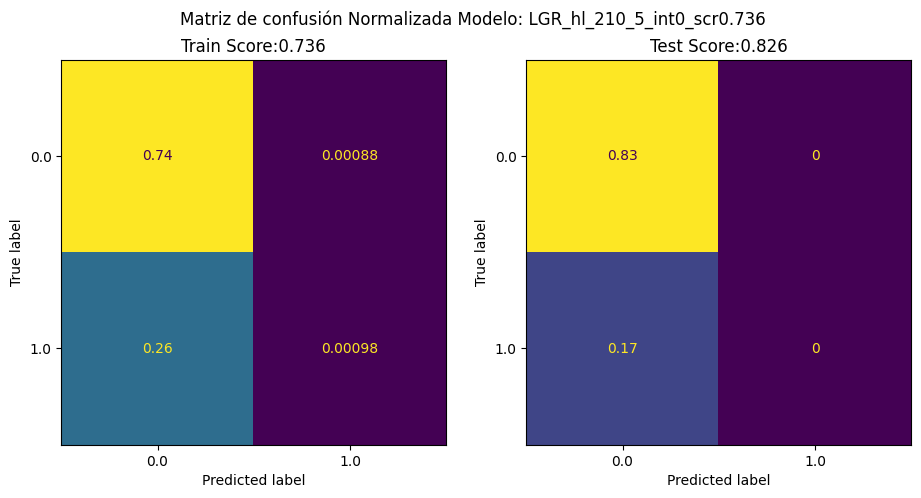

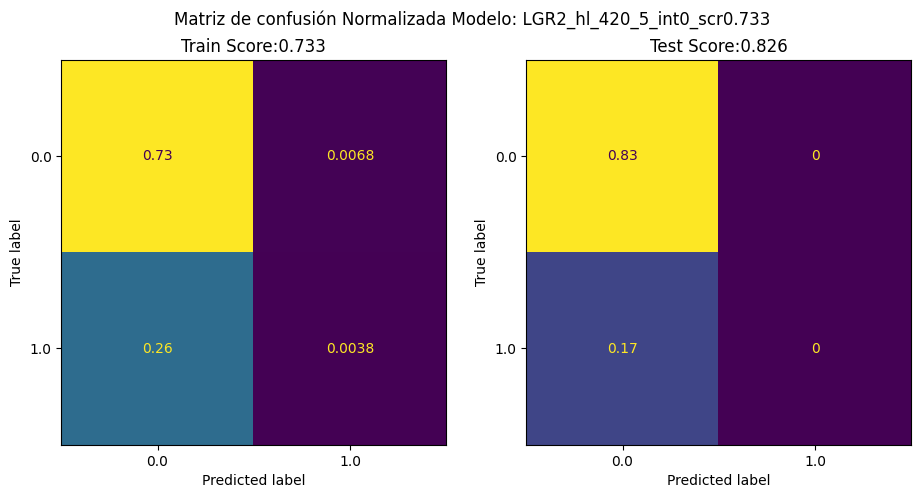

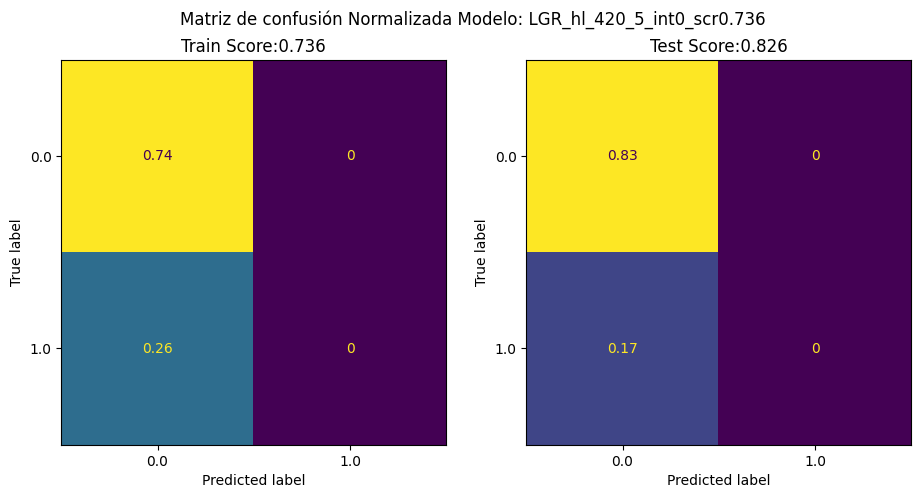

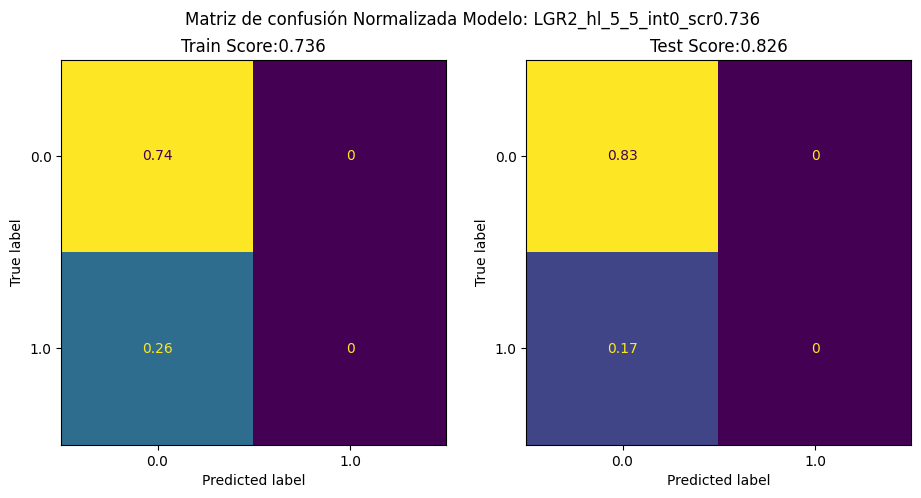

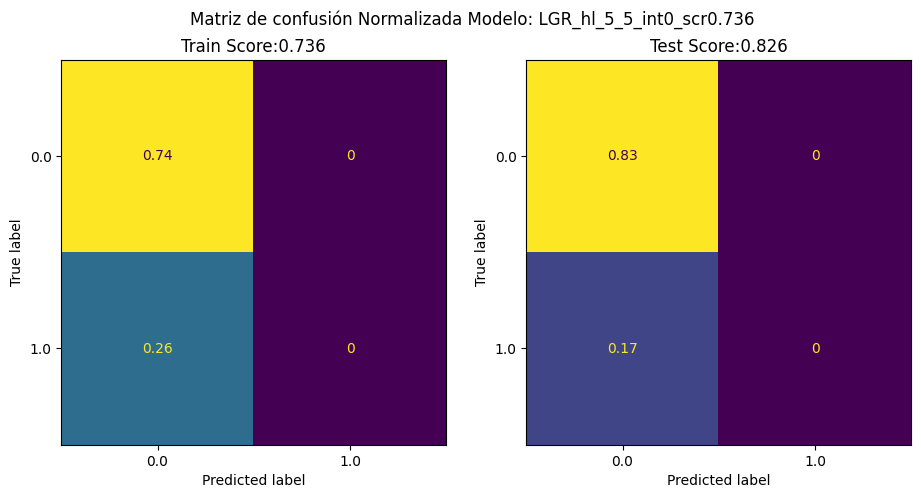

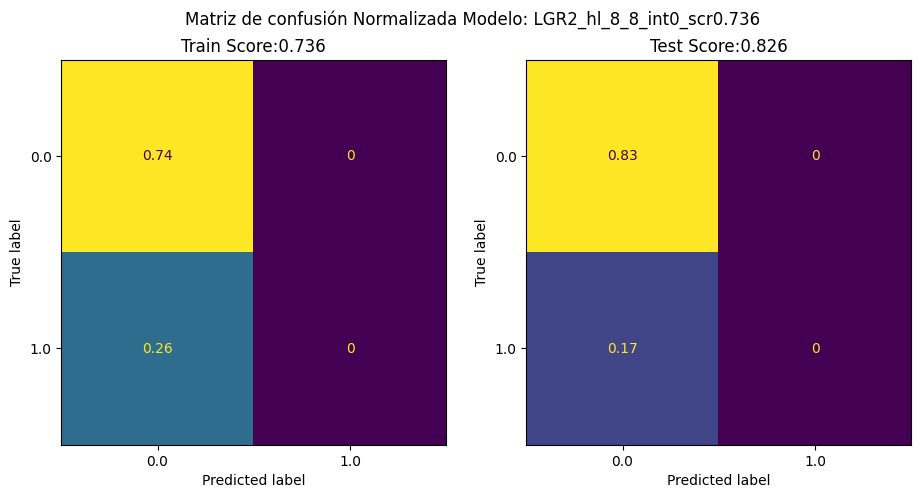

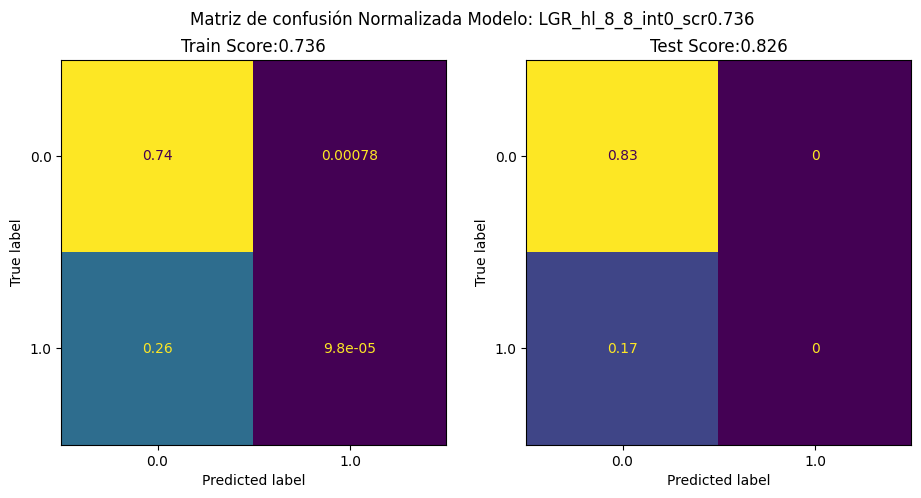

In [ ]:
dictPuntajes = {'Modelo':[],
                'V':[],
                'Train_Score':[],
                'Train_TN':[],
                'Train_FP':[],
                'Train_FN':[],
                'Train_TP':[],
                'Test_Score':[],
                'Test_TN':[],
                'Test_FP':[],
                'Test_FN':[],
                'Test_TP':[]}

for modelo in listaModelos:
  if 'joblib' in modelo:
    if 'LGR_' in modelo:
      Xtest = np.loadtxt(pathDatos+'Todos_LGR__X2022.txt')
      ytest = np.loadtxt(pathDatos+'Todos_LGR__y2022.txt')
      Xtrain = np.loadtxt(pathDatos+'Todos_LGR__X2021.txt')
      ytrain= np.loadtxt(pathDatos+'Todos_LGR__y2021.txt')

    if 'LGR2_' in modelo:
      Xtest = np.loadtxt(pathDatos+'Todos_LGR2__X2022.txt')
      ytest = np.loadtxt(pathDatos+'Todos_LGR2__y2022.txt')
      Xtrain = np.loadtxt(pathDatos+'Todos_LGR2__X2021.txt')
      ytrain= np.loadtxt(pathDatos+'Todos_LGR2__y2021.txt')

    modelo_P = load(pathModelos+modelo)
    # Train
    predichosModelo_Train = modelo_P.predict(Xtrain)
    scoreTrain = np.round(modelo_P.score(Xtrain, ytrain), 3)
    tn_Train, fp_Train, fn_Train, tp_Train = confusion_matrix(ytrain, predichosModelo_Train, normalize='all').ravel()

    # Test
    predichosModelo_Test = modelo_P.predict(Xtest)
    accuracyScore_Test = np.round(accuracy_score(ytest, predichosModelo_Test),3)
    tn_Test, fp_Test, fn_Test, tp_Test = confusion_matrix(ytest, predichosModelo_Test, normalize='all').ravel()

    # Incluir en la lista
    dictPuntajes['Modelo'].append(modelo[:-7])
    dictPuntajes['V'].append('v3')
    dictPuntajes['Train_Score'].append(scoreTrain)
    dictPuntajes['Train_TN'].append(tn_Train)
    dictPuntajes['Train_FP'].append(fp_Train)
    dictPuntajes['Train_FN'].append(fn_Train)
    dictPuntajes['Train_TP'].append(tp_Train)
    dictPuntajes['Test_Score'].append(accuracyScore_Test)
    dictPuntajes['Test_TN'].append(tn_Test)
    dictPuntajes['Test_FP'].append(fp_Test)
    dictPuntajes['Test_FN'].append(fn_Test)
    dictPuntajes['Test_TP'].append(tp_Test)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
    #Train

    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytrain, predichosModelo_Train, normalize='all'),
                           display_labels=modelo_P.classes_,
                           ).plot(ax=axs[0], colorbar=False)
    axs[0].set_title(f'Train Score:{scoreTrain}')

    #Test
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytest, predichosModelo_Test, normalize='all'),
                        display_labels=modelo_P.classes_,
                        ).plot(ax=axs[1], colorbar=False)
    axs[1].set_title(f'Test Score:{accuracyScore_Test}')

    plt.suptitle(f'Matriz de confusión Normalizada Modelo: {modelo[:-7]}')

    plt.savefig((pathSaveFiguras + f'v3_{modelo[:-7]}.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

    plt.show()
    print('\n')


df_V3 = pd.DataFrame.from_dict(dictPuntajes)
#df

In [ ]:
df_V3.to_csv(pathDatos+'df_ConfMatrix_V3.csv', index=False)
df_V3 = pd.read_csv(pathDatos+'df_ConfMatrix_V3.csv')
df_V3

,Modelo,V,Train_Score,Train_TN,Train_FP,Train_FN,Train_TP,Test_Score,Test_TN,Test_FP,Test_FN,Test_TP
0,LGR2_hl_1_1_int0_scr0.736,v3,0.736,0.736269,0.000000,0.263731,0.000000,0.826,0.826309,0.0,0.173691,0.0
1,LGR_hl_1_1_int0_scr0.736,v3,0.736,0.736269,0.000000,0.263731,0.000000,0.826,0.826309,0.0,0.173691,0.0
2,LGR2_hl_1500_5_int0_scr0.736,v3,0.736,0.735386,0.000883,0.263535,0.000196,0.826,0.826309,0.0,0.173691,0.0
3,LGR_hl_1500_5_int0_scr0.736,v3,0.736,0.736269,0.000000,0.263731,0.000000,0.826,0.826309,0.0,0.173691,0.0
4,LGR2_hl_2000_5_int0_scr0.736,v3,0.736,0.735386,0.000883,0.263142,0.000588,0.826,0.826309,0.0,0.173691,0.0
5,LGR_hl_2000_5_int0_scr0.736,v3,0.736,0.736269,0.000000,0.263731,0.000000,0.826,0.826309,0.0,0.173691,0.0
6,LGR2_hl_210_5_int0_scr0.736,v3,0.736,0.736269,0.000000,0.263731,0.000000,0.826,0.826309,0.0,0.173691,0.0
7,LGR_hl_210_5_int0_scr0.736,v3,0.736,0.735386,0.000883,0.262750,0.000981,0.826,0.826309,0.0,0.173691,0.0
8,LGR2_hl_420_5_int0_scr0.733,v3,0.733,0.729502,0.006767,0.259906,0.003825,0.826,0.826309,0.0,0.173691,0.0
9,LGR_hl_420_5_int0_scr0.736,v3,0.736,0.736269,0.000000,0.263731,0.000000,0.826,0.826309,0.0,0.173691,0.0


## V4

In [ ]:
pathModelos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/ModelosMLP_Class_v4/'
pathDatos = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Catalogos/'
pathSaveFiguras = '/content/drive/MyDrive/Manuscritos_Investigacion/ML_SismosNidoBucaramanga/Figuras_MatrizConfusion/'

listaModelos = ['2009_12meses_hl_1500_5_int1_scr0.995.joblib',
                '2009_30dias_hl_210_5_int0_scr1.0.joblib',
                '2009_12meses_hl_2000_5_int0_scr0.987.joblib',
                '2009_30dias_hl_420_5_int0_scr0.998.joblib',
                '2009_12meses_hl_210_5_int0_scr1.0.joblib',
                '2009_6meses_hl_1500_5_int1_scr1.0.joblib',
                '2009_12meses_hl_420_5_int0_scr1.0.joblib',
                '2009_6meses_hl_2000_5_int0_scr0.995.joblib',
                '2009_30dias_hl_1500_5_int0_scr1.0.joblib',
                '2009_6meses_hl_210_5_int0_scr1.0.joblib',
                '2009_30dias_hl_2000_5_int1_scr1.0.joblib',
                '2009_6meses_hl_420_5_int0_scr1.0.joblib']

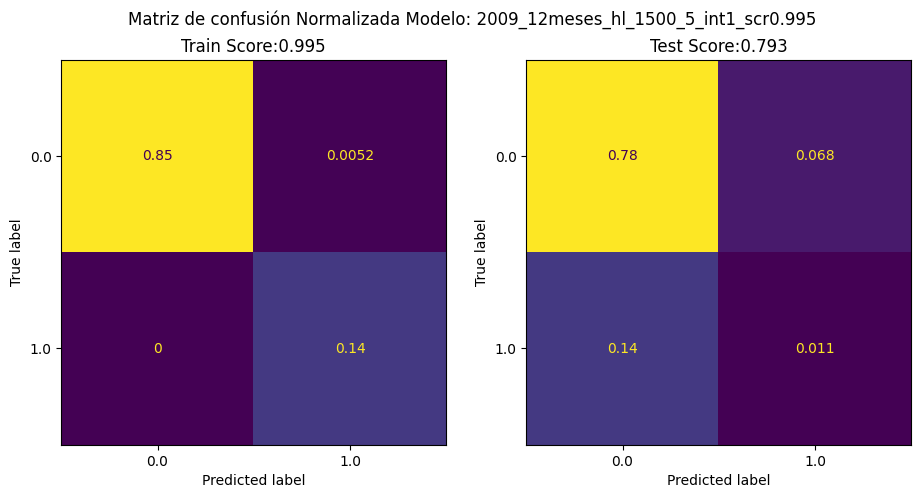

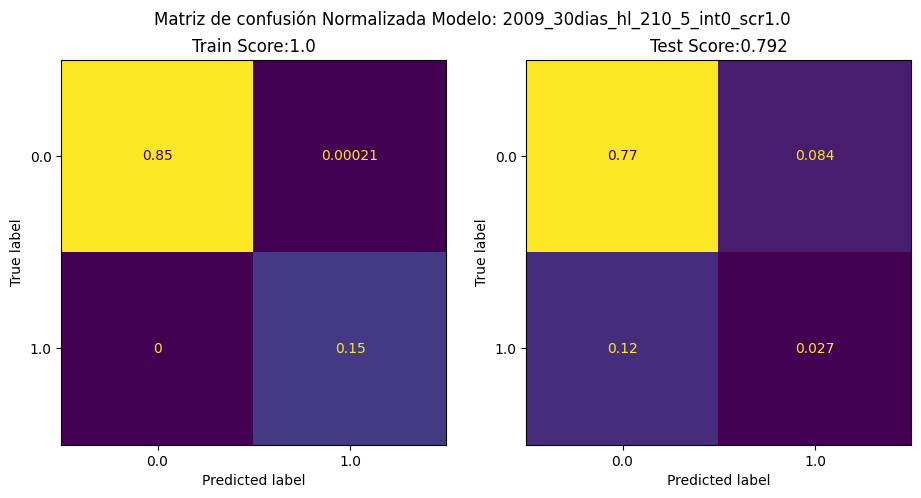

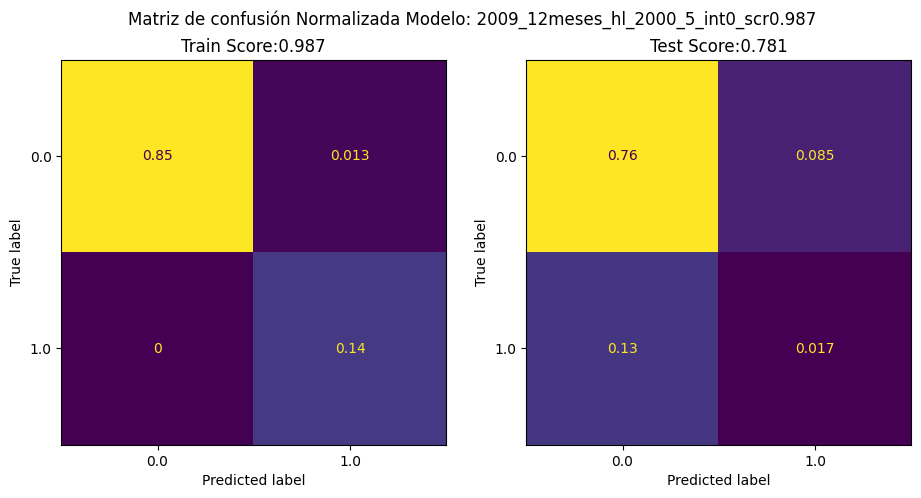

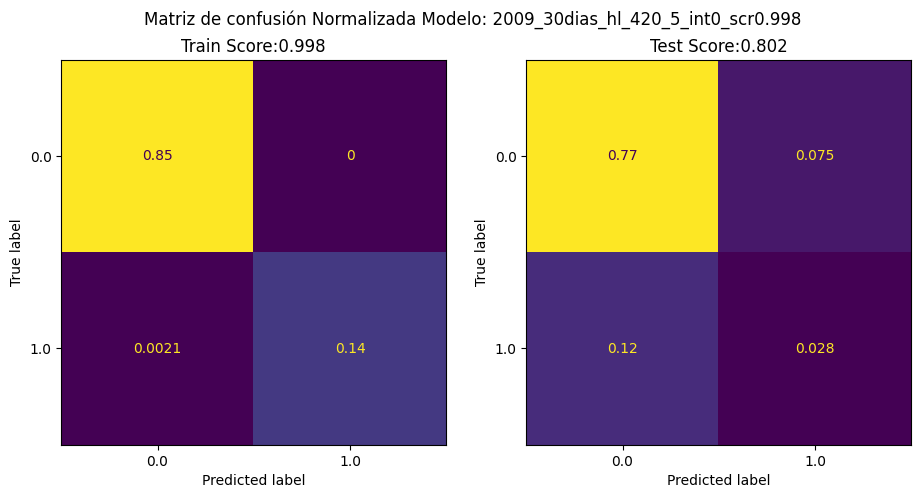

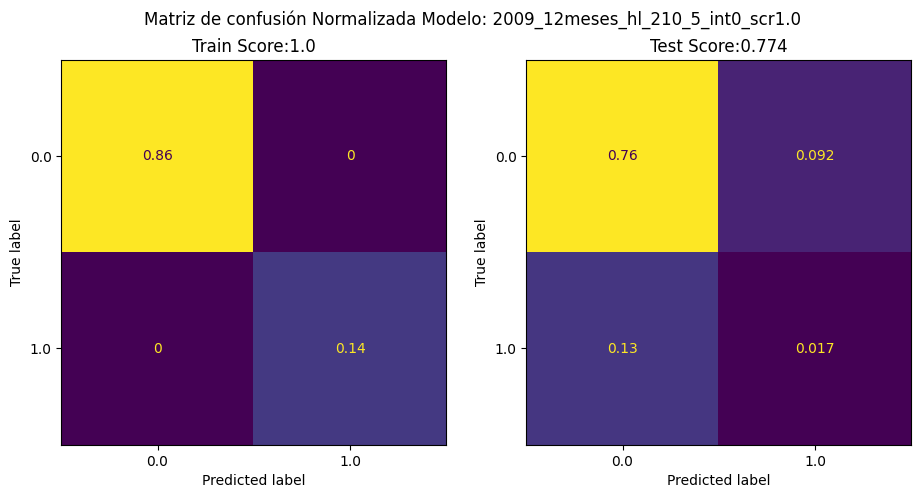

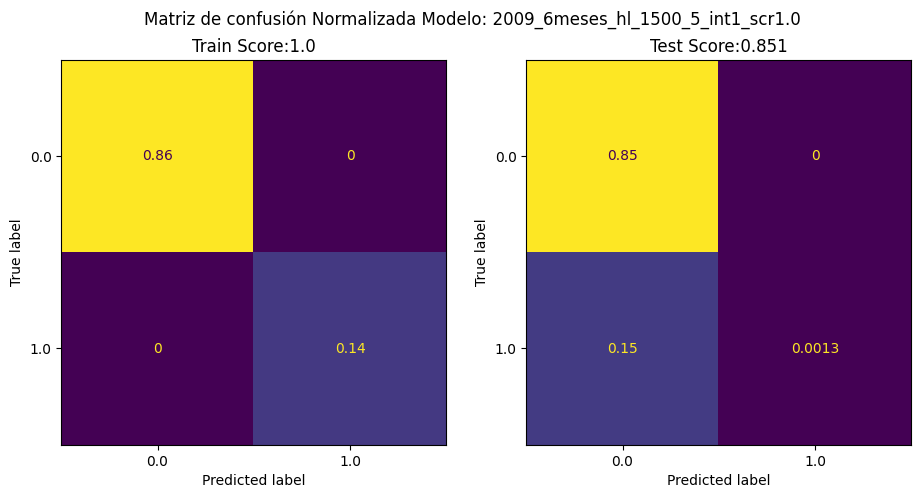

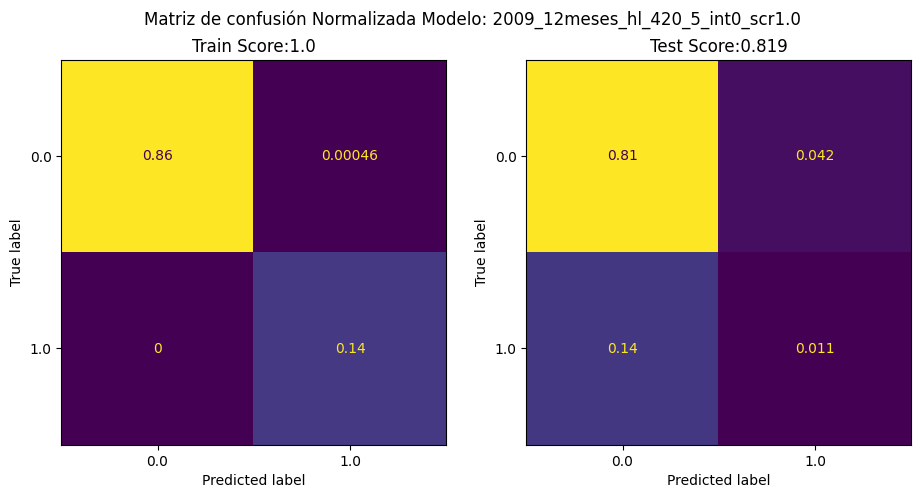

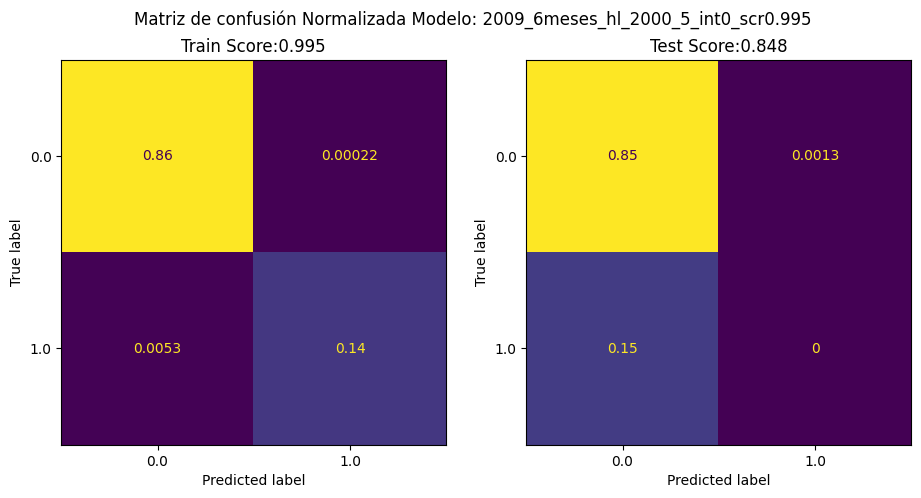

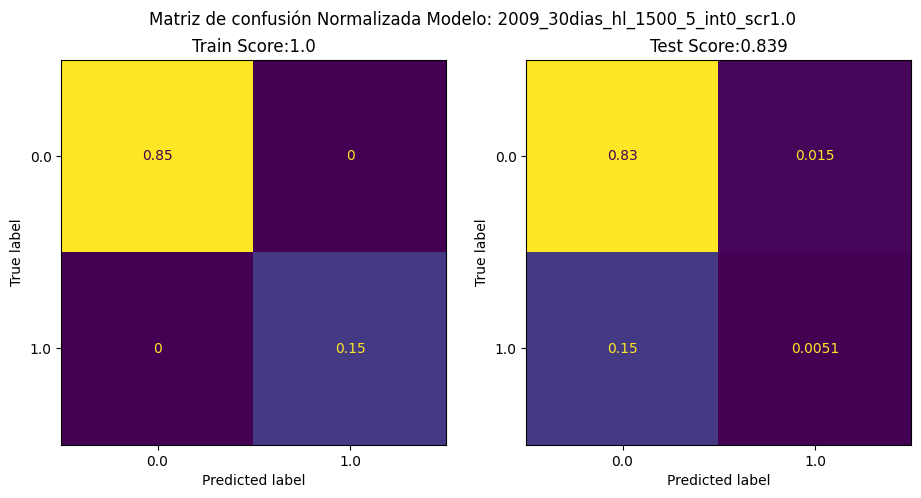

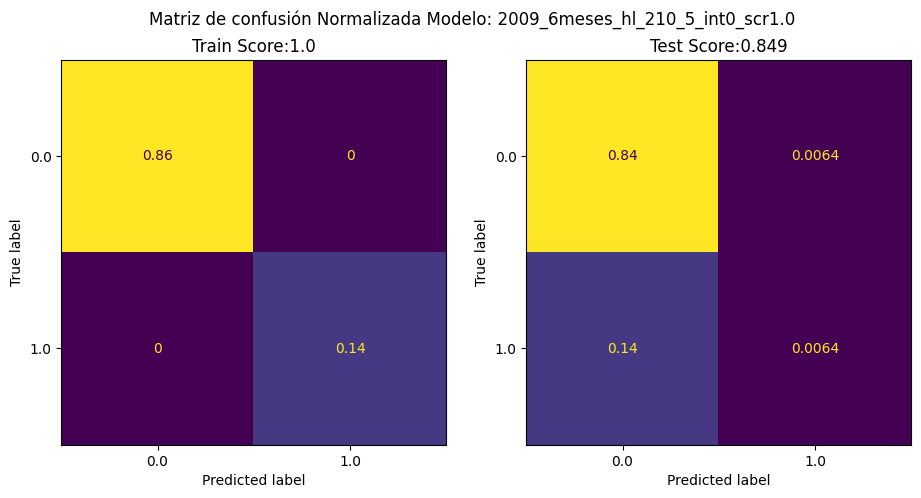

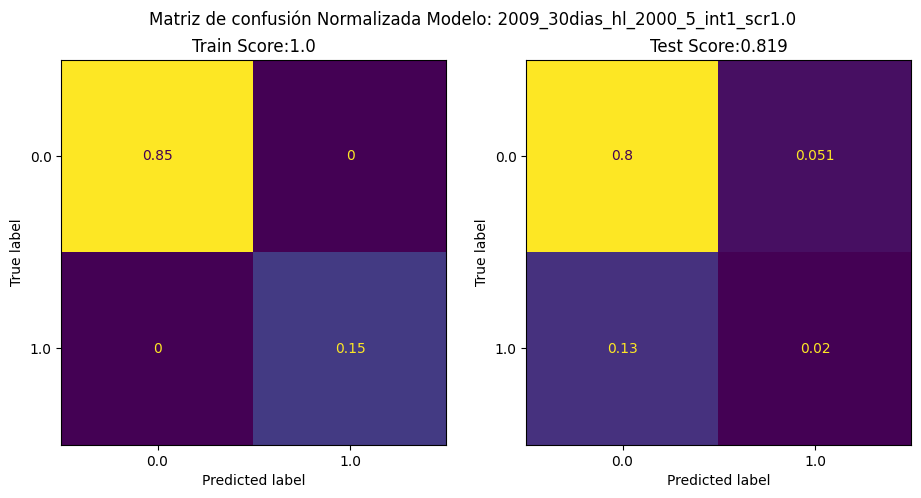

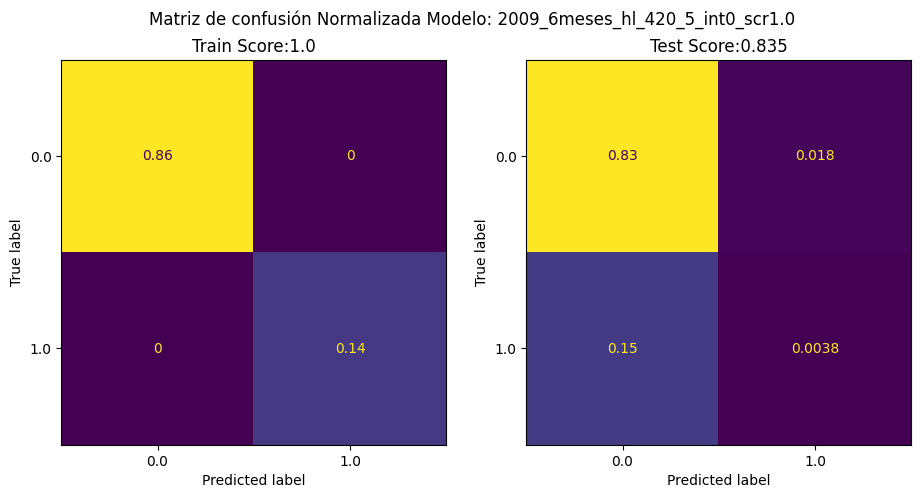

In [ ]:
dictPuntajes = {'Modelo':[],
                'V':[],
                'Train_Score':[],
                'Train_TN':[],
                'Train_FP':[],
                'Train_FN':[],
                'Train_TP':[],
                'Test_Score':[],
                'Test_TN':[],
                'Test_FP':[],
                'Test_FN':[],
                'Test_TP':[]}

for modelo in listaModelos:
  if 'joblib' in modelo:
    if '6meses' in modelo:
      Xtest = np.loadtxt(pathDatos+'2009_6meses_X2022.txt')
      ytest = np.loadtxt(pathDatos+'2009_6meses_y2022.txt')
      Xtrain = np.loadtxt(pathDatos+'2009_6meses_X2021.txt')
      ytrain = np.loadtxt(pathDatos+'2009_6meses_y2021.txt')

    if '12meses' in modelo:
      Xtest = np.loadtxt(pathDatos+'2009_12meses_X2022.txt')
      ytest = np.loadtxt(pathDatos+'2009_12meses_y2022.txt')
      Xtrain = np.loadtxt(pathDatos+'2009_12meses_X2021.txt')
      ytrain = np.loadtxt(pathDatos+'2009_12meses_y2021.txt')

    if '30dias' in modelo:
      Xtest = np.loadtxt(pathDatos+'2009_30dias_X2022.txt')
      ytest = np.loadtxt(pathDatos+'2009_30dias_y2022.txt')
      Xtrain = np.loadtxt(pathDatos+'2009_30dias_X2021.txt')
      ytrain = np.loadtxt(pathDatos+'2009_30dias_y2021.txt')

    modelo_P = load(pathModelos+modelo)
    # Train
    predichosModelo_Train = modelo_P.predict(Xtrain)
    scoreTrain = np.round(modelo_P.score(Xtrain, ytrain), 3)
    tn_Train, fp_Train, fn_Train, tp_Train = confusion_matrix(ytrain, predichosModelo_Train, normalize='all').ravel()

    # Test
    predichosModelo_Test = modelo_P.predict(Xtest)
    accuracyScore_Test = np.round(accuracy_score(ytest, predichosModelo_Test),3)
    tn_Test, fp_Test, fn_Test, tp_Test = confusion_matrix(ytest, predichosModelo_Test, normalize='all').ravel()

    # Incluir en la lista
    dictPuntajes['Modelo'].append(modelo[:-7])
    dictPuntajes['V'].append('v4')
    dictPuntajes['Train_Score'].append(scoreTrain)
    dictPuntajes['Train_TN'].append(tn_Train)
    dictPuntajes['Train_FP'].append(fp_Train)
    dictPuntajes['Train_FN'].append(fn_Train)
    dictPuntajes['Train_TP'].append(tp_Train)
    dictPuntajes['Test_Score'].append(accuracyScore_Test)
    dictPuntajes['Test_TN'].append(tn_Test)
    dictPuntajes['Test_FP'].append(fp_Test)
    dictPuntajes['Test_FN'].append(fn_Test)
    dictPuntajes['Test_TP'].append(tp_Test)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
    #Train

    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytrain, predichosModelo_Train, normalize='all'),
                           display_labels=modelo_P.classes_,
                           ).plot(ax=axs[0], colorbar=False)
    axs[0].set_title(f'Train Score:{scoreTrain}')

    #Test
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ytest, predichosModelo_Test, normalize='all'),
                        display_labels=modelo_P.classes_,
                        ).plot(ax=axs[1], colorbar=False)
    axs[1].set_title(f'Test Score:{accuracyScore_Test}')

    plt.suptitle(f'Matriz de confusión Normalizada Modelo: {modelo[:-7]}')

    plt.savefig((pathSaveFiguras + f'v4_{modelo[:-7]}.png'),
            format='png', dpi=300, bbox_inches = 'tight',pad_inches=0.25)

    plt.show()
    print('\n')


df_V4 = pd.DataFrame.from_dict(dictPuntajes)
#df

In [ ]:
df_V4.to_csv(pathDatos+'df_ConfMatrix_V4.csv', index=False)
df_V4 = pd.read_csv(pathDatos+'df_ConfMatrix_V4.csv')
df_V4

,Modelo,V,Train_Score,Train_TN,Train_FP,Train_FN,Train_TP,Test_Score,Test_TN,Test_FP,Test_FN,Test_TP
0,2009_12meses_hl_1500_5_int1_scr0.995,v4,0.995,0.852874,0.005246,0.000000,0.141880,0.793,0.781888,0.067602,0.139031,0.011480
1,2009_30dias_hl_210_5_int0_scr1.0,v4,1.000,0.854418,0.000212,0.000000,0.145370,0.792,0.765306,0.084184,0.123724,0.026786
2,2009_12meses_hl_2000_5_int0_scr0.987,v4,0.987,0.845575,0.012546,0.000000,0.141880,0.781,0.764031,0.085459,0.133929,0.016582
3,2009_30dias_hl_420_5_int0_scr0.998,v4,0.998,0.854630,0.000000,0.002119,0.143251,0.802,0.774235,0.075255,0.122449,0.028061
4,2009_12meses_hl_210_5_int0_scr1.0,v4,1.000,0.858120,0.000000,0.000000,0.141880,0.774,0.757653,0.091837,0.133929,0.016582
5,2009_6meses_hl_1500_5_int1_scr1.0,v4,1.000,0.856424,0.000000,0.000000,0.143576,0.851,0.849490,0.000000,0.149235,0.001276
6,2009_12meses_hl_420_5_int0_scr1.0,v4,1.000,0.857664,0.000456,0.000000,0.141880,0.819,0.807398,0.042092,0.139031,0.011480
7,2009_6meses_hl_2000_5_int0_scr0.995,v4,0.995,0.856205,0.000219,0.005253,0.138323,0.848,0.848214,0.001276,0.150510,0.000000
8,2009_30dias_hl_1500_5_int0_scr1.0,v4,1.000,0.854630,0.000000,0.000000,0.145370,0.839,0.834184,0.015306,0.145408,0.005102
9,2009_6meses_hl_210_5_int0_scr1.0,v4,1.000,0.856424,0.000000,0.000000,0.143576,0.849,0.843112,0.006378,0.144133,0.006378


# End